In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rdkit-pypi -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 12.4 MB/s eta 0:00:00


In [ ]:
from IPython.display import display_html

import logging
import warnings
import re
import os
import numpy as np
import pandas as pd
import pickle
import sklearn.metrics
import pickle
import requests
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, MACCSkeys
from datetime import date
from typing import Literal, Optional, Union, List, Dict, Tuple, Any, Callable
from collections import defaultdict
pd.set_option('display.max_columns', None)

In [ ]:
working_directory = "/content/drive/MyDrive/Protacs_new_dataset/"
os.chdir(working_directory)
print("current working directory is: ", os.getcwd())

current working directory is:  /content/drive/MyDrive/Protacs_new_dataset


In [ ]:
data_dir = os.path.join(os.getcwd(), 'data')
src_dir = os.path.join(os.getcwd(), 'src')
fig_dir = os.path.join(data_dir, 'figures')
checkpoint_dir = os.path.join(os.getcwd(), 'checkpoints')
dirs_to_make = [
    data_dir,
    os.path.join(data_dir, 'raw'),
    os.path.join(data_dir, 'processed'),
    os.path.join(data_dir, 'train'),
    os.path.join(data_dir, 'val'),
    os.path.join(data_dir, 'test'),
    src_dir,
    fig_dir,
    checkpoint_dir,
]
for d in dirs_to_make:
    if not os.path.exists(d):
        os.makedirs(d)

In [ ]:
protac_df = pd.read_csv("/content/drive/MyDrive/Protacs_new_dataset/protac.csv").reset_index(drop=True)
print("Shape of dataset is: ",protac_df.shape)
protac_df.head()

Shape of dataset is:  (5388, 89)


,Compound ID,Uniprot,Target,E3 ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),Percent degradation (%),Assay (Percent degradation),"IC50 (nM, Protac to Target)","Assay (Protac to Target, IC50)","EC50 (nM, Protac to Target)","Assay (Protac to Target, EC50)","Kd (nM, Protac to Target)","Assay (Protac to Target, Kd)","Ki (nM, Protac to Target)","Assay (Protac to Target, Ki)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)","Assay (Protac to Target, G/H/-TS)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)","Assay (Protac to Target, kon/koff/t1/2)","IC50 (nM, Protac to E3)","Assay (Protac to E3, IC50)","EC50 (nM, Protac to E3)","Assay (Protac to E3, EC50)","Kd (nM, Protac to E3)","Assay (Protac to E3, Kd)","Ki (nM, Protac to E3)","Assay (Protac to E3, Ki)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)","Assay (Protac to E3, G/H/-TS)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)","Assay (Protac to E3, kon/koff/t1/2)","IC50 (nM, Ternary complex)","Assay (Ternary complex, IC50)","EC50 (nM, Ternary complex)","Assay (Ternary complex, EC50)","Kd (nM, Ternary complex)","Assay (Ternary complex, Kd)","Ki (nM, Ternary complex)","Assay (Ternary complex, Ki)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)","Assay (Ternary complex, G/H/-TS)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)","Assay (Ternary complex, kon/koff/t1/2)","IC50 (nM, Cellular activities)","Assay (Cellular activities, IC50)","EC50 (nM, Cellular activities)","Assay (Cellular activities, EC50)","GI50 (nM, Cellular activities)","Assay (Cellular activities, GI50)","ED50 (nM, Cellular activities)","Assay (Cellular activities, ED50)","GR50 (nM, Cellular activities)","Assay (Cellular activities, GR50)","PAMPA Papp (nm/s, Permeability)","Assay (Permeability, PAMPA Papp)","Caco-2 A2B Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 A2B Papp)","Caco-2 B2A Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 B2A Papp)",Article DOI,Molecular Weight,Exact Mass,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key
0,1,Q9NPI1,BRD7,VHL,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01413,953.176,952.451697,3.03,68,7,15,3,19,189.92,C50H64N8O9S,InChI=1S/C50H64N8O9S/c1-32-45(68-31-53-32)34-1...,RPMQBLMPGMFXLD-PDUNVWSESA-N
1,1,Q9H8M2,BRD9,VHL,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,ITC,NaN,NaN,-10.7,-12.5,1.8,ITC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33/24,ITC/FP,NaN,NaN,-10.2,-15.2,4.9,ITC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73/98,ITC/FP,NaN,NaN,-9.7,-6.4,-3.3,ITC between VHL and BRD9-BD:PROTAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01413,953.176,952.451697,3.03,68,7,15,3,19,189.92,C50H64N8O9S,InChI=1S/C50H64N8O9S/c1-32-45(68-31-53-32)34-1...,RPMQBLMPGMFXLD-PDUNVWSESA-N
2,2,Q9NPI1,BRD7,VHL,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01413,1041.282,1040.504126,2.74,74,7,17,3,25,208.38,C54H72N8O11S,InChI=1S/C54H72N8O11S/c

In [ ]:
protac_df.columns

Index(['Compound ID', 'Uniprot', 'Target', 'E3 ligase', 'PDB', 'Name',
       'Smiles', 'DC50 (nM)', 'Dmax (%)', 'Assay (DC50/Dmax)',
       'Percent degradation (%)', 'Assay (Percent degradation)',
       'IC50 (nM, Protac to Target)', 'Assay (Protac to Target, IC50)',
       'EC50 (nM, Protac to Target)', 'Assay (Protac to Target, EC50)',
       'Kd (nM, Protac to Target)', 'Assay (Protac to Target, Kd)',
       'Ki (nM, Protac to Target)', 'Assay (Protac to Target, Ki)',
       'delta G (kcal/mol, Protac to Target)',
       'delta H (kcal/mol, Protac to Target)',
       '-T*delta S (kcal/mol, Protac to Target)',
       'Assay (Protac to Target, G/H/-TS)', 'kon (1/Ms, Protac to Target)',
       'koff (1/s, Protac to Target)', 't1/2 (s, Protac to Target)',
       'Assay (Protac to Target, kon/koff/t1/2)', 'IC50 (nM, Protac to E3)',
       'Assay (Protac to E3, IC50)', 'EC50 (nM, Protac to E3)',
       'Assay (Protac to E3, EC50)', 'Kd (nM, Protac to E3)',
       'Assay (Protac to E3, 

## **Uniprot id is referring to POI target**

In [ ]:
protac_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5388 entries, 0 to 5387
Data columns (total 89 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Compound ID                              5388 non-null   int64  
 1   Uniprot                                  5196 non-null   object 
 2   Target                                   5388 non-null   object 
 3   E3 ligase                                5388 non-null   object 
 4   PDB                                      25 non-null     object 
 5   Name                                     2333 non-null   object 
 6   Smiles                                   5388 non-null   object 
 7   DC50 (nM)                                905 non-null    object 
 8   Dmax (%)                                 726 non-null    object 
 9   Assay (DC50/Dmax)                        1008 non-null   object 
 10  Percent degradation (%)                  362 non

In [ ]:
no_uniprot_df = protac_df.loc[protac_df['Uniprot'].isna() & (~protac_df['Assay (DC50/Dmax)'].notna() | ~protac_df['Assay (Percent degradation)'].notna()), :] #['Assay (Percent degradation)', 'Assay (DC50/Dmax)', 'Article DOI']]
print("Shape of dataset is: ",no_uniprot_df.shape)
no_uniprot_df.head()

Shape of dataset is:  (192, 89)


,Compound ID,Uniprot,Target,E3 ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),Percent degradation (%),Assay (Percent degradation),"IC50 (nM, Protac to Target)","Assay (Protac to Target, IC50)","EC50 (nM, Protac to Target)","Assay (Protac to Target, EC50)","Kd (nM, Protac to Target)","Assay (Protac to Target, Kd)","Ki (nM, Protac to Target)","Assay (Protac to Target, Ki)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)","Assay (Protac to Target, G/H/-TS)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)","Assay (Protac to Target, kon/koff/t1/2)","IC50 (nM, Protac to E3)","Assay (Protac to E3, IC50)","EC50 (nM, Protac to E3)","Assay (Protac to E3, EC50)","Kd (nM, Protac to E3)","Assay (Protac to E3, Kd)","Ki (nM, Protac to E3)","Assay (Protac to E3, Ki)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)","Assay (Protac to E3, G/H/-TS)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)","Assay (Protac to E3, kon/koff/t1/2)","IC50 (nM, Ternary complex)","Assay (Ternary complex, IC50)","EC50 (nM, Ternary complex)","Assay (Ternary complex, EC50)","Kd (nM, Ternary complex)","Assay (Ternary complex, Kd)","Ki (nM, Ternary complex)","Assay (Ternary complex, Ki)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)","Assay (Ternary complex, G/H/-TS)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)","Assay (Ternary complex, kon/koff/t1/2)","IC50 (nM, Cellular activities)","Assay (Cellular activities, IC50)","EC50 (nM, Cellular activities)","Assay (Cellular activities, EC50)","GI50 (nM, Cellular activities)","Assay (Cellular activities, GI50)","ED50 (nM, Cellular activities)","Assay (Cellular activities, ED50)","GR50 (nM, Cellular activities)","Assay (Cellular activities, GR50)","PAMPA Papp (nm/s, Permeability)","Assay (Permeability, PAMPA Papp)","Caco-2 A2B Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 A2B Papp)","Caco-2 B2A Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 B2A Papp)",Article DOI,Molecular Weight,Exact Mass,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key
463,316,NaN,BCR-ABL,CRBN,NaN,BOS-6-2-2-CRBN,COC1=CC(NC2=C(C#N)C=NC3=CC(OCCCN4CCN(CCCCCCOCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28/0.11,Kd of non-phosphorylated/phosphorylated ABL wa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1002/anie.201507634,973.912,972.333995,6.17,68,7,15,3,23,213.99,C48H54Cl2N8O10,InChI=1S/C48H54Cl2N8O10/c1-64-39-26-37(33(49)2...,OHGOKRHLLKPKJK-UHFFFAOYSA-N
464,317,NaN,BCR-ABL,CRBN,NaN,BOS-6-2-2-6-CRBN,COC1=CC(NC2=C(C#N)C=NC3=CC(OCCCN4CCN(CCCCCCOCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.91/0.55,Kd of non-phosphorylated/phosphorylated ABL wa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1002/anie.201507634,1074.073,1072.422810,7.00,75,7,16,3,30,223.22,C54H66Cl2N8O11,InChI=1S/C54H66Cl2N8O11/c1-70-45-33-43(39(55)3...,MKHTUOFMIYFSEP-UHFFFAOYSA-N
465,318,NaN,BCR-ABL,CRBN,NaN,BOS-6-5-6-CRBN,COC1=CC(NC2=C(C#N)C=NC3=CC(OCCCN4CCN(CCCCCCOCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8/1.1,Kd of non-phosphorylated/phosphorylated ABL wa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
# Missing uniprot entries are filled with "Unknown"
protac_df = protac_df.fillna(value={'Uniprot': 'Unknown'})
print('protac_df: {:,} x {:,}'.format(*protac_df.shape))

protac_df: 5,388 x 89


In [ ]:
unknown_uniprot_df = protac_df[protac_df['Uniprot'].str.contains("Unknown", na=False)]
unknown_uniprot_df


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),Percent degradation (%),Assay (Percent degradation),"IC50 (nM, Protac to Target)","Assay (Protac to Target, IC50)","EC50 (nM, Protac to Target)","Assay (Protac to Target, EC50)","Kd (nM, Protac to Target)","Assay (Protac to Target, Kd)","Ki (nM, Protac to Target)","Assay (Protac to Target, Ki)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)","Assay (Protac to Target, G/H/-TS)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)","Assay (Protac to Target, kon/koff/t1/2)","IC50 (nM, Protac to E3)","Assay (Protac to E3, IC50)","EC50 (nM, Protac to E3)","Assay (Protac to E3, EC50)","Kd (nM, Protac to E3)","Assay (Protac to E3, Kd)","Ki (nM, Protac to E3)","Assay (Protac to E3, Ki)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)","Assay (Protac to E3, G/H/-TS)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)","Assay (Protac to E3, kon/koff/t1/2)","IC50 (nM, Ternary complex)","Assay (Ternary complex, IC50)","EC50 (nM, Ternary complex)","Assay (Ternary complex, EC50)","Kd (nM, Ternary complex)","Assay (Ternary complex, Kd)","Ki (nM, Ternary complex)","Assay (Ternary complex, Ki)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)","Assay (Ternary complex, G/H/-TS)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)","Assay (Ternary complex, kon/koff/t1/2)","IC50 (nM, Cellular activities)","Assay (Cellular activities, IC50)","EC50 (nM, Cellular activities)","Assay (Cellular activities, EC50)","GI50 (nM, Cellular activities)","Assay (Cellular activities, GI50)","ED50 (nM, Cellular activities)","Assay (Cellular activities, ED50)","GR50 (nM, Cellular activities)","Assay (Cellular activities, GR50)","PAMPA Papp (nm/s, Permeability)","Assay (Permeability, PAMPA Papp)","Caco-2 A2B Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 A2B Papp)","Caco-2 B2A Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 B2A Papp)",Article DOI,Molecular Weight,Exact Mass,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,poi_seq,Smiles_no_stereo,e3_ligase_gene,e3_ligase_seq
1085,731,Unknown,RAR,IAP,NaN,NaN,CC(C)C[C@H](NC(=O)[C@@H](O)[C@H](N)Cc1ccccc1)C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1016/j.bmc.2011.09.041,917.154,916.519759,4.36,66,3,11,6,28,224.84,C51H72N4O11,InChI=1S/C51H72N4O11/c1-34(2)27-42(55-48(60)46...,ZAOSGDCLGNWLSI-ACALULJJSA-N,Unknown,CC(C)CC(NC(=O)C(O)C(N)Cc1ccccc1)C(=O)NCCOCCOCC...,Q7Z460,MEPRMESCLAQVLQKDVGKRLQVGQELIDYFSDKQKSADLEHDQTM...
1468,1041,Unknown,PDE4,IAP,NaN,SNIPER(PDE4)-9,CN[C@@H](C)C(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(C(...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1074/jbc.M116.768853,1137.194,1135.425847,7.70,78,7,17,4,32,231.01,C56H71Cl2N7O12S,InChI=1S/C56H71Cl2N7O12S/c1-36(59-2)54(69)64-4...,SLXVHAKRSWDHJT-NWMLSJNZSA-N,Unknown,CNC(C)C(=O)NC(C(=O)N1CCCC1c1nc(C(=O)c2cccc(OCC...,P98170,MTFNSFEGSKTCVPADINKEEEFVEEFNRLKTFANFPSGSPVSAST...
1943,1357,Unknown,NS3,CRBN,NaN,DGY-03-081,CCC[C@H](NC(=O)[C@@H]1[C@H]2CCC[C@H]2CN1C(=O)[...,669,NaN,Degradation of NS3 in Huh7.5 cells after 4 h t...,NaN,NaN,385,Inhibition of NS3,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
protac_df.loc[(protac_df['Target'] == 'BCR-ABL') & (protac_df['Uniprot'] == 'Unknown'), 'Uniprot'] = 'A9UF07'

## The Uniprot ID will be used to get the protein sequence. The gene ID will be instead used to apply specific mutations to the protein sequence. In fact, multiples genes might refer to the same protein, but with different mutations.

In [ ]:
protac_df = protac_df.rename(columns={"Target" : "poi_gene_id"})

## **Get Amino acid sequence from uniprot database**

In [ ]:
poi_sequences_filepath = os.path.join(data_dir, 'processed', 'poi_sequences.pkl')
failed = False
if os.path.exists(poi_sequences_filepath):
    with open(poi_sequences_filepath, 'rb') as f:
        seqs = pickle.load(f)
else:
    cID = list(set(protac_df['Uniprot'].tolist()))
    seqs = {}
    for c in cID:
        try:
            baseUrl = 'http://www.uniprot.org/uniprot/'
            currentUrl = baseUrl + c + '.fasta'
            response = requests.post(currentUrl)
            cData = ''.join(response.text)
            i = cData.index('\n') + 1
            seq = cData[i:].rstrip().replace('\n', '')
            seqs[c] = seq
            # print(f'Getting {cData} from URL: {currentUrl}')
        except:
            print(f'Error getting {c} from URL: {currentUrl}')
            failed = True
    if not failed:
        with open(poi_sequences_filepath, 'wb') as f:
            pickle.dump(seqs, f)
# Add 'Unknown' sequences corresponding to 'Unknown' genes/POIs
seqs['Unknown'] = 'Unknown'

In [ ]:
protac_df['poi_seq'] = protac_df['Uniprot'].map(seqs)

## **Applying gene mutations**

> Same Uniprot ID can have different gene mutations

In [ ]:
# checking if there is more than one gene for each Uniprot ID.

protac_df_grouped = protac_df.groupby('Uniprot')['poi_gene_id'].apply(lambda x: ','.join(x.unique())).reset_index()
for i, row in protac_df_grouped.iterrows():
  if ',' in row['poi_gene_id']:
    print(f"Gene for Uniprot ID {row['Uniprot']}: {row['poi_gene_id']}")


Gene for Uniprot ID O60674: JAK2,JAK2 R683G
Gene for Uniprot ID O60885: BRD4,BRD4 BD1
Gene for Uniprot ID O75533: SF3B1,SF3B1 K400E
Gene for Uniprot ID P00533: EGFR,EGFR L858R/T790M,EGFR e19d,EGFR L858R,EGFR L858R/T790M/C797S,EGFR L858R/T790M/L718Q,EGFR del19/T790M/C797S
Gene for Uniprot ID P01116: KRAS G12C,KRAS
Gene for Uniprot ID P10275: AR,AR-V7,AR T878A
Gene for Uniprot ID P15056: BRAF,BRAF V600E,BRAF V600K,BRAF K601E,BRAF G466E,BRAF D594N,BRAF G466V,BRAF G469A
Gene for Uniprot ID P25440: BRD2,BRD2 BD2
Gene for Uniprot ID P36888: FLT3,FLT3-ITD,FLT3-ITD-D835V,FLT3-ITD-F691L
Gene for Uniprot ID P62942: FKBP12,FKBP12 F36V
Gene for Uniprot ID Q06124: SHP2,SHP2 F285S
Gene for Uniprot ID Q06187: BTK,BTK C481S,BTK C481T,BTK C481G,BTK C481W,BTK C481A
Gene for Uniprot ID Q15059: BRD3,BRD3 BD1
Gene for Uniprot ID Q9NYV4: CDK12,CDK12 C1039F
Gene for Uniprot ID Q9UM73: ALK,ALK G1202R
Gene for Uniprot ID Unknown: RAR,PDE4,Alpha-tubulin,NS3,BCR-ABL T315I,BCR-ABL E255K,BCR-ABL H396R,BCR-ABL V468

In [ ]:
def apply_mutation(uniprot: str, gene: str, seq: str, on_error: Literal['raise', 'ignore'] = 'raise') -> str:
    """Apply mutation to the sequence if possible."""
    if gene == 'Unknown' or seq == 'Unknown' or len(gene.split(' ')) == 1 or gene.startswith('BRD'):
        return seq
    exceptions = {
        ('O60885', 'BRD4 BD1'): seqs['O60885'],
        ('P25440', 'BRD2 BD2'): seqs['P25440'],
        ('P10275', 'AR-V7'): seqs['P10275'],
        ('P00533', 'EGFR e19d'): seqs['P10275'],
    }
    if (uniprot, gene) in exceptions:
        return exceptions[(uniprot, gene)]
    else:
        original_seq = seq
        mutation = gene.split(' ')[1]
        operations = mutation.split('/') if '/' in mutation else [mutation]
        del_ops = 0
        for op in operations:
            if 'del' in op.lower():
                idx = int(op.split('del')[1]) - 1
                seq = seq[:idx] + seq[idx + 1:]
                del_ops += 1
            else:
                curr, idx, new = op[0].upper(), int(op[1:-1])-1, op[-1].upper()
                idx -= del_ops
                if curr != seq[idx]:
                    msg = f'Replacement at position {idx} failed. Expected "{curr}", found: "{seq[idx]}".'
                    if on_error == 'raise':
                        raise ValueError('ERROR. ' + msg)
                    else:
                        print('WARNING. ' + msg + ' No mutation applied.')
                        return original_seq
                seq = seq[:idx] + new + seq[idx + 1:]
        return seq

example = protac_df.loc[protac_df['poi_gene_id'] == 'EGFR L858R/T790M', ['Uniprot', 'poi_gene_id', 'poi_seq']].iloc[0]
uniprot, gene, seq = example['Uniprot'], example['poi_gene_id'], example['poi_seq']
print(seq)
print(apply_mutation(uniprot, gene, seq, on_error='ignore'))
print(apply_mutation(uniprot, 'EGFR del19/T790M/C797S', seq, on_error='ignore'))
print(apply_mutation(uniprot, 'EGFR', seq, on_error='ignore'))

MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRA

In [ ]:
for index, row in protac_df.iterrows():
    protac_df.at[index, 'poi_seq'] = apply_mutation(row['Uniprot'], row['poi_gene_id'], row['poi_seq'], on_error='ignore')

WARNING. Replacement at position 35 failed. Expected "F", found: "K". No mutation applied.
WARNING. Replacement at position 35 failed. Expected "F", found: "K". No mutation applied.
WARNING. Replacement at position 35 failed. Expected "F", found: "K". No mutation applied.
WARNING. Replacement at position 35 failed. Expected "F", found: "K". No mutation applied.
WARNING. Replacement at position 35 failed. Expected "F", found: "K". No mutation applied.
WARNING. Replacement at position 35 failed. Expected "F", found: "K". No mutation applied.
WARNING. Replacement at position 399 failed. Expected "K", found: "S". No mutation applied.


## **Converting SMILES to Canonical SMILES**

In [ ]:
smile_tmp = protac_df.dropna(subset=['Smiles'])
print(f"Number of entries with SMILES: {len(smile_tmp)}")
print(f"Number of unique SMILES: {len(smile_tmp['Smiles'].unique())}")

Number of entries with SMILES: 5388
Number of unique SMILES: 3270


In [ ]:
canonize_smiles = lambda smiles: Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
protac_df['Smiles'] = protac_df['Smiles'].apply(canonize_smiles)

In [ ]:
# prompt: write a function to remove stereochemisrty from smiles molecules and save it in a new column

def remove_stereo(smiles):
  mol = Chem.MolFromSmiles(smiles)
  Chem.rdmolops.RemoveStereochemistry(mol)
  return Chem.MolToSmiles(mol)

protac_df['Smiles_no_stereo'] = protac_df['Smiles'].apply(remove_stereo)


In [ ]:
tmp = protac_df.dropna(subset=['Smiles_no_stereo'])
print(f"Number of entries with non-stereo SMILES: {len(tmp)}")
print(f"Number of unique non-stereo  SMILES: {len(tmp['Smiles_no_stereo'].unique())}")

Number of entries with non-stereo SMILES: 5388
Number of unique non-stereo  SMILES: 3253


## **Processing E3 ligase**

In [ ]:
protac_df = protac_df.rename(columns = {"E3 ligase" : "e3_ligase"})

In [ ]:
tmp = protac_df["e3_ligase"].value_counts()
tmp

e3_ligase
CRBN      3530
VHL       1578
cIAP1       95
MDM2        56
XIAP        49
IAP         46
AhR          9
FEM1B        9
DCAF15       4
DCAF16       4
RNF114       4
DCAF11       3
RNF4         1
Name: count, dtype: int64

> We have 13 unique E3 ligases

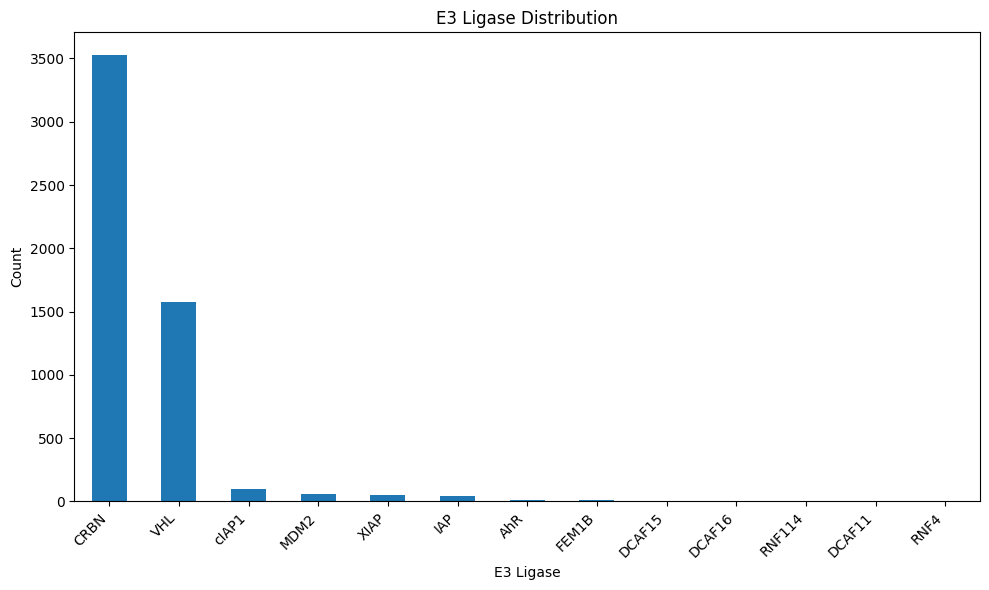

In [ ]:
# prompt: plot e3 ligase distribution

plt.figure(figsize=(10, 6))
protac_df["e3_ligase"].value_counts().plot(kind='bar')
plt.title('E3 Ligase Distribution')
plt.xlabel('E3 Ligase')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
print(f'E3 ligase names: {protac_df["e3_ligase"].unique()}')

E3 ligase names: ['VHL' 'CRBN' 'DCAF15' 'MDM2' 'cIAP1' 'XIAP' 'DCAF16' 'AhR' 'IAP' 'RNF4'
 'RNF114' 'DCAF11' 'FEM1B']


### **Assigning gene ID to E3 ligase entries**

## **DIDN'T FIND GENE ID FOR IAP**

In [ ]:
e3ligase2genes = {
    'VHL': 'P40337',
    'CRBN': 'Q96SW2',
    'DCAF11': 'Q8TEB1',
    'DCAF15': 'Q66K64',
    'DCAF16': 'Q9NXF7',
    'MDM2': 'Q00987',
    'XIAP': 'P98170',
    'cIAP1': 'Q7Z460', # I THINK IT'S CLAP1
    'IAP': 'P98170', # I couldn't find the Uniprot ID for this one, so it's XIAP
    'AhR': 'P35869',
    'RNF4': 'P78317',
    'RNF114': 'Q9Y508',
    'FEM1B': 'Q9UK73',
}
protac_df['e3_ligase_gene'] = protac_df['e3_ligase'].map(e3ligase2genes)
protac_df['e3_ligase_gene']

0       P40337
1       P40337
2       P40337
3       P40337
4       Q96SW2
         ...  
5383    Q9UK73
5384    Q9UK73
5385    Q9UK73
5386    Q96SW2
5387    Q96SW2
Name: e3_ligase_gene, Length: 5388, dtype: object

In [ ]:
e3_ligase_sequences_filepath = os.path.join(data_dir, 'processed', 'e3_ligase_sequences.pkl')
failed = False
if os.path.exists(e3_ligase_sequences_filepath):
    with open(e3_ligase_sequences_filepath, 'rb') as f:
        e3_seqs = pickle.load(f)
else:
    cID = list(set(protac_df['e3_ligase_gene'].tolist()))
    e3_seqs = {}
    for c in cID:
        baseUrl = 'http://www.uniprot.org/uniprot/'
        currentUrl = baseUrl + c + '.fasta'
        try:
            response = requests.post(currentUrl)
            cData = ''.join(response.text)
            i = cData.index('\n') + 1
            seq = cData[i:].rstrip().replace('\n', '')
            e3_seqs[c] = seq
            print(f'Getting {cData} from URL: {currentUrl}')
        except:
            print(f'Error getting {c} from URL: {currentUrl}')
            failed = True
    if not failed:
        with open(e3_ligase_sequences_filepath, 'wb') as f:
            pickle.dump(e3_seqs, f)
# Add 'Unknown' sequences corresponding to 'Unknown' genes/POIs
e3_seqs['Unknown'] = 'Unknown'

Getting >sp|Q7Z460|CLAP1_HUMAN CLIP-associating protein 1 OS=Homo sapiens OX=9606 GN=CLASP1 PE=1 SV=1
MEPRMESCLAQVLQKDVGKRLQVGQELIDYFSDKQKSADLEHDQTMLDKLVDGLATSWVN
SSNYKVVLLGMDILSALVTRLQDRFKAQIGTVLPSLIDRLGDAKDSVREQDQTLLLKIMD
QAANPQYVWDRMLGGFKHKNFRTREGICLCLIATLNASGAQTLTLSKIVPHICNLLGDPN
SQVRDAAINSLVEIYRHVGERVRADLSKKGLPQSRLNVIFTKFDEVQKSGNMIQSANDKN
FDDEDSVDGNRPSSASSTSSKAPPSSRRNVGMGTTRRLGSSTLGSKSSAAKEGAGAVDEE
DFIKAFDDVPVVQIYSSRDLEESINKIREILSDDKHDWEQRVNALKKIRSLLLAGAAEYD
NFFQHLRLLDGAFKLSAKDLRSQVVREACITLGHLSSVLGNKFDHGAEAIMPTIFNLIPN
SAKIMATSGVVAVRLIIRHTHIPRLIPVITSNCTSKSVAVRRRCFEFLDLLLQEWQTHSL
ERHISVLAETIKKGIHDADSEARIEARKCYWGFHSHFSREAEHLYHTLESSYQKALQSHL
KNSDSIVSLPQSDRSSSSSQESLNRPLSAKRSPTGSTTSRASTVSTKSVSTTGSLQRSRS
DIDVNAAASAKSKVSSSSGTTPFSSAAALPPGSYASLGRIRTRRQSSGSATNVASTPDNR
GRSRAKVVSQSQRSRSANPAGAGSRSSSPGKLLGSGYGGLTGGSSRGPPVTPSSEKRSKI
PRSQGCSRETSPNRIGLARSSRIPRPSMSQGCSRDTSRESSRDTSPARGFPPLDRFGLGQ
PGRIPGSVNAMRVLSTSTDLEAAVADALKKPVRRRYEPYGMYSDDDANSDASSVCSERSY
GSRNGGIPHYLRQTEDVAEVLNHCASSNWSERKEGLLGLQNLLK

In [ ]:
protac_df['e3_ligase_seq'] = protac_df['e3_ligase_gene'].map(e3_seqs)
protac_df['e3_ligase_seq'].head()

0    MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...
1    MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...
2    MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...
3    MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...
4    MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...
Name: e3_ligase_seq, dtype: object

### **Combining sub-classes of E3 together:**

In [ ]:
for i in range(len(protac_df['e3_ligase'])):
    if 'IAP' in str(protac_df.iloc[i].at['e3_ligase']):
        protac_df.at[i, 'e3_ligase'] = 'IAP'
    elif 'DCAF' in str(protac_df.iloc[i].at['e3_ligase']):
        protac_df.at[i, 'e3_ligase'] = 'DCAF'
    elif 'RNF' in str(protac_df.iloc[i].at['e3_ligase']):
        protac_df.at[i, 'e3_ligase'] = 'RNF'

In [ ]:
tmp = protac_df.groupby('e3_ligase', as_index=False).size().sort_values('size', ascending=False, ignore_index=True)
print(f"column: {'e3_ligase'}  (#unique:{tmp.shape[0]:,})")
print(tmp.head(20).T, "\n")

column: e3_ligase  (#unique:8)
              0     1    2     3     4    5      6    7
e3_ligase  CRBN   VHL  IAP  MDM2  DCAF  AhR  FEM1B  RNF
size       3530  1578  190    56    11    9      9    5 



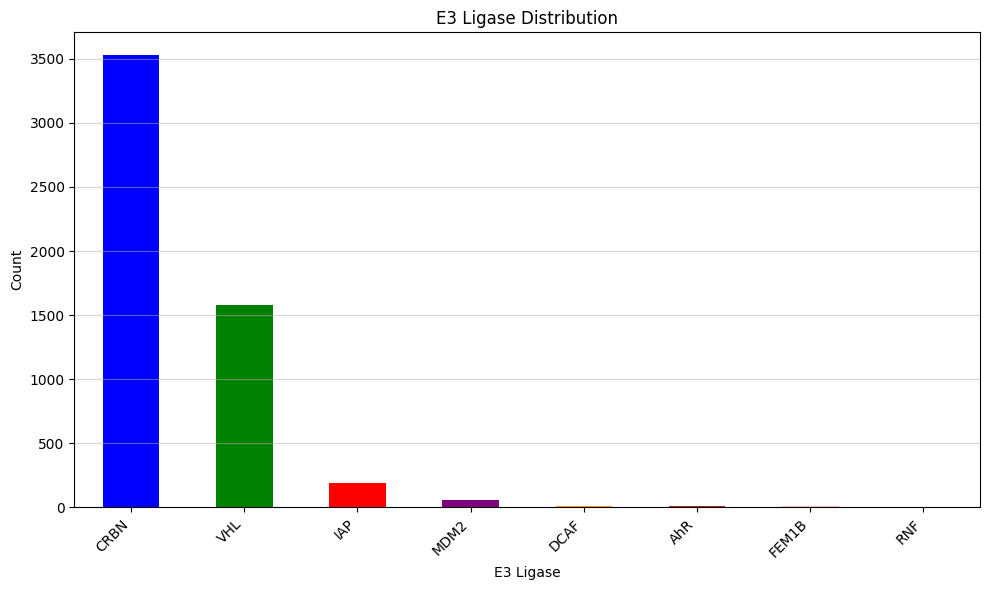

In [ ]:
plt.figure(figsize=(10, 6))
e3_counts = protac_df["e3_ligase"].value_counts()

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

e3_counts.plot(kind='bar', color=colors[:len(e3_counts)])

plt.title('E3 Ligase Distribution')
plt.xlabel('E3 Ligase')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

## **Obtaining information from Assay Description**

For each entry, there are two scenarios possible:

* Each value separated by the slashes in the DC50 (nM) column represents the
 value collected for a specific cell type or POI
    > Example: "Degradation of AR in A549/LNCaP cells after 24 h treatment"
* Each value separated by the slashes in the Percent degradation (%) column represents the degradation percentage in a single cell at different concentrations (in nM).
    - Example: "% AR degradation in LNCaP cells after 6 h treatment at 10/100/1000 nM"
    - **Here, "hook effect" entries might occur, i.e., where with higher concentrations we instead see lower degradation percentanges**
    - For two entries (just two! Imagine how sick and messy this dataset can get!) 😒 the slashes correspond to different POIs:
        * Example: "% EGFR L858R/T790M degradation in H1975 cells after 24 h treatment at 100/1000 nM"
        * Example: "% EGFR L858R/T790M degradation in H1975 cells after 24 h treatment at 10/100 nM"

In [ ]:
for i, a in enumerate(protac_df['Assay (DC50/Dmax)'].unique()):
    print(a)
    if i > 20:
        break
print('-' * 80)
for i, a in enumerate(protac_df['Assay (Percent degradation)'].unique()):
    print(a)
    if i > 20:
        break

nan
Degradation of BRD9 in HeLa cells after 4 h treatment
Degradation of BRD9 in RI-1 cells after 8 h treatment
Degradation of HiBiT-BRD9 in HEK293 cells after 24 h treatment using CRISPR/Cas9
Degradation of BRD9 in EOL-1/A-204 cells after 18 h treatment on a WES capillary electrophoresis instrument
Degradation of BRD7 in RI-1 cells after 8 h treatment
Degradation of HiBiT-BRD7 in HEK293 cells after 24 h treatment using CRISPR/Cas9
Degradation of ER in MCF-7/T47D cells after 4 h treatment
Degradation of AR in LNCaP/VCaP AR+ cells after 6 h treatment
Degradation of AR in LNCaP/VCaP/22Rv1 cells after 24 h treatment
Degradation of BRD4 in NCI-H661/NCI-H838 cells after 4h treatment
Degradation of CRBN in HEK293T cells after 24h treatment
Degradation of CRBN in MM1S cells after 24h treatment
Degradation of p38alpha in MDA-MB-231 cells
Degradation of p38delta in MDA-MB-231 cells
Degradation of p38alpha in MDA-MB-231 cells after 24 h treatment
Degradation of BRD2
Degradation of BRD3
Degradati

In [ ]:
# THIS DOSEN'T WORKS WELL
cellosaurus_api = 'https://web.expasy.org/cellosaurus/api/search/cell-line'

query = 'RS4;11'
url = f'{cellosaurus_api}?q={query.rstrip()}&fields=id,sy,idsy'

response = requests.get(url)

if response.status_code == 200:
    search_results = response.json()
    print(search_results)

    for k in search_results:
        print(search_results[k])
        for k2 in search_results[k]:
            print(k2, search_results[k][k2])
            for l in search_results[k][k2]:
                print(l)
else:
    print('Request failed with status code', response.status_code)

{'Cellosaurus': {'cell-line-list': [{'name-list': [{'type': 'identifier', 'value': 'RS4;11'}, {'type': 'synonym', 'value': 'RS4-11'}, {'type': 'synonym', 'value': 'RS4:11'}, {'type': 'synonym', 'value': 'RS 4;11'}, {'type': 'synonym', 'value': 'RS(4;11)'}, {'type': 'synonym', 'value': 'RS411'}, {'type': 'identifier', 'value': 'RS4;11'}, {'type': 'synonym', 'value': 'RS4-11'}, {'type': 'synonym', 'value': 'RS4:11'}, {'type': 'synonym', 'value': 'RS 4;11'}, {'type': 'synonym', 'value': 'RS(4;11)'}, {'type': 'synonym', 'value': 'RS411'}]}, {'name-list': [{'type': 'identifier', 'value': 'RS4;11 BCL2-F104L'}, {'type': 'identifier', 'value': 'RS4;11 BCL2-F104L'}]}, {'name-list': [{'type': 'identifier', 'value': 'RS4;11 BCL2-G101V'}, {'type': 'identifier', 'value': 'RS4;11 BCL2-G101V'}]}]}}
{'cell-line-list': [{'name-list': [{'type': 'identifier', 'value': 'RS4;11'}, {'type': 'synonym', 'value': 'RS4-11'}, {'type': 'synonym', 'value': 'RS4:11'}, {'type': 'synonym', 'value': 'RS 4;11'}, {'type

### **Note:** The cell types are not consistent, meaning that the same cell is called in different ways, e.g., 'PACA-2' and 'PACA2'.

**Extract The cell names using NER**
**Model taken from here:** https://huggingface.co/tlemberger/sd-ner

In [ ]:
import torch
from transformers import (pipeline,
                          RobertaTokenizerFast,
                          RobertaForTokenClassification)

if torch.cuda.is_available():
    device = 0
else:
    device = torch.device('cpu')

tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_len=512)
# model = RobertaForTokenClassification.from_pretrained('EMBO/sd-ner')
model = RobertaForTokenClassification.from_pretrained('tlemberger/sd-ner')
ner = pipeline('ner', model, tokenizer=tokenizer, device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/496M [00:00<?, ?B/s]

### Mapping of labels used in a Named Entity Recognition (NER) task and processes example text to extract relevant information about genes and cells.

In [ ]:
label2entity = {
    'LABEL_0': 'O',
    'LABEL_1': 'I-SMALL_MOLECULE',
    'LABEL_2': 'B-SMALL_MOLECULE',
    'LABEL_3': 'I-GENEPROD',
    'LABEL_4': 'B-GENEPROD',
    'LABEL_5': 'I-SUBCELLULAR',
    'LABEL_6': 'B-SUBCELLULAR',
    'LABEL_7': 'I-CELL',
    'LABEL_8': 'B-CELL',
    'LABEL_9': 'I-TISSUE',
    'LABEL_10': 'B-TISSUE',
    'LABEL_11': 'I-ORGANISM',
    'LABEL_12': 'B-ORGANISM',
    'LABEL_13': 'I-EXP_ASSAY',
    'LABEL_14': 'B-EXP_ASSAY',
}

# TODO: The following should be a dictionary of lists of possible synonyms. For
# example the cells 'PACA-2' and 'PACA2' should be identified as the same one!

# Add the following cells if one-to-one match in input text
undetected_cells = {
    'XLA': ['XLA'],
    # 'EGFP/mCherry': ['EGFP/mCherry'],
    'Ba/F3': ['Ba/F3'],
    'Mino': ['Mino'],
    'IgE MM': ['IgE MM'],
    'IL2 PBMC': ['IL2 PBMC'],
}

# Remove the following cells if one-to-one match in input text
false_pos_cells = {
    'BA',
    'F3',
    'DEL19',
}

false_pos_genes = {
    'IL2',
}

# The key will be the final gene ID to add, the value will be a list of possible
# synonyms in the text to match
undetected_genes = {
    'BRD4 short': ['BRD4 short'],
    'BRD4 long': ['BRD4 short/long'],
    'EGFR L858R': ['EGFR L858R'],
    'T790M': ['T790M'],
}

def parse_assay_text(input_text):
    parsed_info = {}
    # Separate the cell types with a "stronger" token like "and", instead of "/"
    cleaned_text = input_text.replace('/', ' and ')
    # Run Named Entity Recognition on it
    labeled_text = ner(cleaned_text)
    # Aggregate the cell-labeled sub-words/tokens into words
    lst2str = lambda lst: ''.join(lst).replace('Ġ', '')
    genes, gene_word = [], []
    cells, cell_word = [], []
    for token in labeled_text:
        # Process Cell-labeled tokens
        if '-CELL' in label2entity[token['entity']]:
            cell_word.append(token['word'])
        if 'O' == label2entity[token['entity']] and cell_word != []:
            cells.append(lst2str(cell_word).upper())
            cell_word = []
        # Process Gene-labeled tokens
        if 'GENE' in label2entity[token['entity']]:
            gene_word.append(token['word'])
        if 'O' == label2entity[token['entity']] and gene_word != []:
            genes.append(lst2str(gene_word).upper())
            gene_word = []
    # Add missing genes
    for geneid, synonyms in undetected_genes.items():
        for gene in synonyms:
            if gene in input_text and gene.upper() not in genes:
                genes.append(geneid)
    # Handle special cases...
    if 'short/long' in input_text.lower() and 'BRD4' in genes:
        genes.remove('BRD4')
    if 'EGFR' in genes:
        genes.remove('EGFR')
    # Remove false-positives genes
    for gene in false_pos_genes:
        if gene in genes:
            genes.remove(gene)
    # Add missing cell types
    for cellid, synonyms in undetected_cells.items():
        for cell in synonyms:
            if cell in input_text and cell.upper() not in cells:
                cells.append(cellid)
    # Remove false-positives cells
    for cell in false_pos_cells:
        if cell in cells:
            cells.remove(cell)
    # Fill default if not found
    if cells == []:
        cells = ['Unknown']
    if genes == []:
        genes = ['Unknown']
    # Parse treatment time from assay description
    if 'after' in input_text.lower() and 'h treatment' in input_text.lower():
        time_str = input_text.lower().split('after')[1].split('treatment')[0]
        treatment_hours = re.findall(r'\d+', time_str)
    else:
        treatment_hours = ['Unknown']
    # Parse concentration for entries not displaying DC50
    if re.search(f'at [0-9.\/]+', input_text.lower()):
        search_txt = input_text.split('at')[-1]
        if 'nM' in search_txt:
            concentrations = re.findall(r'[0-9.]+', search_txt)
        else:
            concentrations = ['Unknown']
    else:
        concentrations = ['Unknown']
    # Store all parsed information in a dictionary
    parsed_info['genes'] = genes
    parsed_info['cells'] = cells
    parsed_info['treatment_hours'] = treatment_hours
    parsed_info['concentrations'] = concentrations
    return parsed_info

# NOTE: One entry has a SPACE(!) in "RS4; 11", but the cell type is "RS4;11"
example = 'Degradation of BCL-xL in MOLT-4/RS4; 11 cells'
parsed_info = parse_assay_text(example)
genes, cells = parsed_info['genes'], parsed_info['cells']
print(f'POI from genes {"/".join(genes)} degraded in cells: {"/".join(cells)}. Info: {parsed_info}')

# DC50 (nM) -> 100/1000
example = 'Degradation of ALK in H3122/Karpas 299 cells' # Assay DC50
parsed_info = parse_assay_text(example)
genes, cells = parsed_info['genes'], parsed_info['cells']
print(f'POI from genes {"/".join(genes)} degraded in cells: {"/".join(cells)}. Info: {parsed_info}')

example = 'Degradation of BRD4 short/long in HeLa cells at 24 h treatment'
parsed_info = parse_assay_text(example)
genes, cells = parsed_info['genes'], parsed_info['cells']
print(f'POI from genes {"/".join(genes)} degraded in cells: {"/".join(cells)}. Info: {parsed_info}')

# DC (%) -> 40/75/43
example = '% AR degradation in LNCaP cells after 6 h at 0.1/1000/10000 nM'
example = '% AR degradation in LNCaP cells after 6 h treatment at 0.1/1000/10000 nM'
parsed_info = parse_assay_text(example)
genes, cells = parsed_info['genes'], parsed_info['cells']
print(f'POI from genes {"/".join(genes)} degraded in cells: {parsed_info}')

# 'EGFR L858R/T790M' -> ['EGFR L858R', 'T790M']
example = '% EGFR L858R/T790M degradation in H1975 cells after 24 h treatment at 10/100 nM'
parsed_info = parse_assay_text(example)
genes, cells = parsed_info['genes'], parsed_info['cells']
print(f'POI from genes {"/".join(genes)} degraded in cells: {parsed_info}')

example = 'Inhibit IFNgamma signalling in IL2 PBMC cells'
parsed_info = parse_assay_text(example)
genes, cells = parsed_info['genes'], parsed_info['cells']
print(f'POI from genes {"/".join(genes)} degraded in cells: {parsed_info}')

POI from genes BCL-XL degraded in cells: MOLT-4/RS4;11. Info: {'genes': ['BCL-XL'], 'cells': ['MOLT-4', 'RS4;11'], 'treatment_hours': ['Unknown'], 'concentrations': ['Unknown']}
POI from genes ALK degraded in cells: H3122/KARPAS299. Info: {'genes': ['ALK'], 'cells': ['H3122', 'KARPAS299'], 'treatment_hours': ['Unknown'], 'concentrations': ['Unknown']}
POI from genes BRD4 short/BRD4 long degraded in cells: HELA. Info: {'genes': ['BRD4 short', 'BRD4 long'], 'cells': ['HELA'], 'treatment_hours': ['Unknown'], 'concentrations': ['Unknown']}
POI from genes AR degraded in cells: {'genes': ['AR'], 'cells': ['LNCAP'], 'treatment_hours': ['6'], 'concentrations': ['0.1', '1000', '10000']}
POI from genes EGFR L858R/T790M degraded in cells: {'genes': ['EGFR L858R', 'T790M'], 'cells': ['H1975'], 'treatment_hours': ['24'], 'concentrations': ['10', '100']}
POI from genes IFNGAMMA degraded in cells: {'genes': ['IFNGAMMA'], 'cells': ['PBMC', 'IL2 PBMC'], 'treatment_hours': ['Unknown'], 'concentrations':

## **Degradation Activity: pDC50 and Dmax**

Now the "messy part" begins. We need to clean the degradation activity data. To do so, we need to:

* Define a set of parsing functions to extract information from the "Assay Description" columns
* Setup different dataframes to store the entries with missing information


Create a global dictionary to store the dataframes as list of dictionaries (i.e., one dictionary per row):

In [ ]:
dataframes = defaultdict(pd.DataFrame)
dataframes

defaultdict(pandas.core.frame.DataFrame, {})

## **Entries with N.D. (Not Degrading)**
Entries with
 as "Not Degrading" are saved to a separate dataframe, marked as inactive, and removed from the current dataframe.

    Parsed 'weird entries' with 'rows with "Assay (Percent degradation)" and n.1 points on the dose-response curve', might also be marked as inactive, since all of them have zero Dmax...

    Handle case in which their assay description is not NaN, because it might contain cell type information. For now, since all assays are empty, the cell type is marked as unkown.

For example:

* In column "Assay (Cellular activities, IC50)":
    * Inhibit growth of RS4;11 cells
    * Inhibit proliferation of PC-3 cells
    * Inhibit IFNgamma signalling in IL2 PBMC cells
    * Inhibit proliferation of H358/MiaPaCa2 cells
    * Inhibit viability of HeLa cells
    * Inhibit proliferation of A431 cells
    * Inhibit proliferation of HCC-827 cells
    * Inhibit growth of MCF-7/MDA-MB-231 cells
* In column "Assay (Cellular activities, EC50)":
    * Inhibit proliferation of EBC-1 cells
    * Inhibit proliferation of GIST-T1/Kasumi 1 cells

In [ ]:
nodegr_df = protac_df[protac_df['Dmax (%)'] == 'N.D.'].copy()
nodegr_df['Dmax (%)'] = nodegr_df['Dmax (%)'].replace({'N.D.': 'NaN'})
nodegr_df['cell_type'] = 'Unknown'
nodegr_df['treatment_hours'] = 'NaN'
nodegr_df['active'] = False
nodegr_df['hook_effect'] = float('nan')
# Print some information
print(f'nodegr_df.shape: {nodegr_df.shape}')
for assay in ['Assay (DC50/Dmax)', 'Assay (Percent degradation)']:
    print('-' * 80)
    print(f'Printing unique assay descriptions for "{assay}":')
    print('-' * 80)
    for a in nodegr_df[assay].unique():
        print(a)
# NOTE: We can set all the values to NaN, because we know that these entries are
# missing in the original dataset
nodegr_df['DC50'] = float('nan')
nodegr_df['pDC50'] = float('nan')
nodegr_df['Dmax'] = float('nan')
if nodegr_df['Dmax (%)'].notnull().any():
    print('WARNING. There are entries with non-null "Dmax (%)" column')
if nodegr_df['DC50 (nM)'].notnull().any():
    print('WARNING. There are entries with non-null "DC50 (nM)" column')

nodegr_df.shape: (299, 97)
--------------------------------------------------------------------------------
Printing unique assay descriptions for "Assay (DC50/Dmax)":
--------------------------------------------------------------------------------
nan
--------------------------------------------------------------------------------
Printing unique assay descriptions for "Assay (Percent degradation)":
--------------------------------------------------------------------------------
nan
WARNING. There are entries with non-null "Dmax (%)" column


In [ ]:
nodegr_df

,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),Percent degradation (%),Assay (Percent degradation),"IC50 (nM, Protac to Target)","Assay (Protac to Target, IC50)","EC50 (nM, Protac to Target)","Assay (Protac to Target, EC50)","Kd (nM, Protac to Target)","Assay (Protac to Target, Kd)","Ki (nM, Protac to Target)","Assay (Protac to Target, Ki)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)","Assay (Protac to Target, G/H/-TS)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)","Assay (Protac to Target, kon/koff/t1/2)","IC50 (nM, Protac to E3)","Assay (Protac to E3, IC50)","EC50 (nM, Protac to E3)","Assay (Protac to E3, EC50)","Kd (nM, Protac to E3)","Assay (Protac to E3, Kd)","Ki (nM, Protac to E3)","Assay (Protac to E3, Ki)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)","Assay (Protac to E3, G/H/-TS)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)","Assay (Protac to E3, kon/koff/t1/2)","IC50 (nM, Ternary complex)","Assay (Ternary complex, IC50)","EC50 (nM, Ternary complex)","Assay (Ternary complex, EC50)","Kd (nM, Ternary complex)","Assay (Ternary complex, Kd)","Ki (nM, Ternary complex)","Assay (Ternary complex, Ki)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)","Assay (Ternary complex, G/H/-TS)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)","Assay (Ternary complex, kon/koff/t1/2)","IC50 (nM, Cellular activities)","Assay (Cellular activities, IC50)","EC50 (nM, Cellular activities)","Assay (Cellular activities, EC50)","GI50 (nM, Cellular activities)","Assay (Cellular activities, GI50)","ED50 (nM, Cellular activities)","Assay (Cellular activities, ED50)","GR50 (nM, Cellular activities)","Assay (Cellular activities, GR50)","PAMPA Papp (nm/s, Permeability)","Assay (Permeability, PAMPA Papp)","Caco-2 A2B Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 A2B Papp)","Caco-2 B2A Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 B2A Papp)",Article DOI,Molecular Weight,Exact Mass,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,poi_seq,Smiles_no_stereo,e3_ligase_gene,e3_ligase_seq,cell_type,treatment_hours,active,hook_effect,DC50,pDC50,Dmax
89,54,Q00987,MDM2,VHL,NaN,NaN,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,Inhibit growth of RS4;11 cells,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b00909,1108.178,1106.405801,8.05,77,9,10,7,15,210.96,C58H65Cl2FN8O7S,InChI=1S/C58H65Cl2FN8O7S/c1-32(34-15-17-35(18-...,TWICUUFPTXMBLR-SCCNDQITSA-N,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,Cc1ncsc1-c1ccc(C(C)NC(=O)C2CC(O)CN2C(=O)C(NC(=...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,Unknown,NaN,False,NaN,NaN,NaN,NaN
90,55,Q00987,MDM2,VHL,NaN,NaN,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500,Inhibit growth of RS4;11 cells,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b00909,1168.230,1166.426930,7.04,81,9,12,7,19,229.42,C60H69Cl2FN8O9S,InChI=1S/C60H69Cl2FN8O9S/c1-34(36-12-14-37(15-...,NSASIVMDKWNVIM-OMVGZGIZSA-N,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,Cc1ncsc1-c1ccc(C(C)NC(=O)C2CC(O)CN2C(=O)C(NC(=...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEE

In [ ]:
assays_to_check = [
    'Assay (Cellular activities, IC50)',
    'Assay (Cellular activities, EC50)',
]
parsed_table = []
for i, row in enumerate(nodegr_df.to_dict(orient='records')):
    # Parse the first encountered assay text that is not empty
    assay_to_check = None
    for assay in assays_to_check:
        if str(row[assay]) != 'nan':
            assay_to_check = assay
            break
    if assay_to_check is not None:
        # print(row[assay])
        parsed_info = parse_assay_text(row[assay_to_check])
        genes = parsed_info['genes']
        cells = parsed_info['cells']
        treatment_hours = parsed_info['treatment_hours']
        rows_to_add = []
        for j, cell_type in enumerate(cells):
            row['active'] = False
            # Add extra information from the parsed assay description
            row['poi_gene_id_parsed'] = genes[j % len(genes)]
            row['cell_type'] = cells[j % len(cells)]
            row['treatment_hours'] = treatment_hours[j % len(treatment_hours)]
            rows_to_add.append(row.copy())
        parsed_table.extend(rows_to_add)
        if len(parsed_table) % 50 == 0:
            print(f'Current length of parsed table: {len(parsed_table)}')
    else:
        # Empty assays, add the row as is
        parsed_table.append(row)
        if len(parsed_table) % 50 == 0:
            print(f'Current length of parsed table: {len(parsed_table)}')
print(f'Current length of parsed table: {len(parsed_table)}')
nodegr_df = pd.DataFrame(parsed_table).fillna(value={'Uniprot': 'Unknown'})
display(nodegr_df.head())

Current length of parsed table: 50
Current length of parsed table: 100
Current length of parsed table: 150
Current length of parsed table: 200
Current length of parsed table: 250
Current length of parsed table: 300
Current length of parsed table: 339


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),Percent degradation (%),Assay (Percent degradation),"IC50 (nM, Protac to Target)","Assay (Protac to Target, IC50)","EC50 (nM, Protac to Target)","Assay (Protac to Target, EC50)","Kd (nM, Protac to Target)","Assay (Protac to Target, Kd)","Ki (nM, Protac to Target)","Assay (Protac to Target, Ki)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)","Assay (Protac to Target, G/H/-TS)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)","Assay (Protac to Target, kon/koff/t1/2)","IC50 (nM, Protac to E3)","Assay (Protac to E3, IC50)","EC50 (nM, Protac to E3)","Assay (Protac to E3, EC50)","Kd (nM, Protac to E3)","Assay (Protac to E3, Kd)","Ki (nM, Protac to E3)","Assay (Protac to E3, Ki)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)","Assay (Protac to E3, G/H/-TS)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)","Assay (Protac to E3, kon/koff/t1/2)","IC50 (nM, Ternary complex)","Assay (Ternary complex, IC50)","EC50 (nM, Ternary complex)","Assay (Ternary complex, EC50)","Kd (nM, Ternary complex)","Assay (Ternary complex, Kd)","Ki (nM, Ternary complex)","Assay (Ternary complex, Ki)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)","Assay (Ternary complex, G/H/-TS)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)","Assay (Ternary complex, kon/koff/t1/2)","IC50 (nM, Cellular activities)","Assay (Cellular activities, IC50)","EC50 (nM, Cellular activities)","Assay (Cellular activities, EC50)","GI50 (nM, Cellular activities)","Assay (Cellular activities, GI50)","ED50 (nM, Cellular activities)","Assay (Cellular activities, ED50)","GR50 (nM, Cellular activities)","Assay (Cellular activities, GR50)","PAMPA Papp (nm/s, Permeability)","Assay (Permeability, PAMPA Papp)","Caco-2 A2B Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 A2B Papp)","Caco-2 B2A Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 B2A Papp)",Article DOI,Molecular Weight,Exact Mass,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,poi_seq,Smiles_no_stereo,e3_ligase_gene,e3_ligase_seq,cell_type,treatment_hours,active,hook_effect,DC50,pDC50,Dmax,poi_gene_id_parsed
0,54,Q00987,MDM2,VHL,NaN,NaN,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,Inhibit growth of RS4;11 cells,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b00909,1108.178,1106.405801,8.05,77,9,10,7,15,210.96,C58H65Cl2FN8O7S,InChI=1S/C58H65Cl2FN8O7S/c1-32(34-15-17-35(18-...,TWICUUFPTXMBLR-SCCNDQITSA-N,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,Cc1ncsc1-c1ccc(C(C)NC(=O)C2CC(O)CN2C(=O)C(NC(=...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,RS4;11,Unknown,False,NaN,NaN,NaN,NaN,Unknown
1,55,Q00987,MDM2,VHL,NaN,NaN,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500,Inhibit growth of RS4;11 cells,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b00909,1168.230,1166.426930,7.04,81,9,12,7,19,229.42,C60H69Cl2FN8O9S,InChI=1S/C60H69Cl2FN8O9S/c1-34(36-12-14-37(15-...,NSASIVMDKWNVIM-OMVGZGIZSA-N,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,Cc1ncsc1-c1ccc(C(C)NC(=O)C2CC(O)CN2C(=O)C(NC(=...,P40337

In [ ]:
print('Lenght PROTAC-DB:', len(protac_df))
print('Lenght N.D. entries:', len(protac_df[protac_df['Dmax (%)'] == 'N.D.']))
print('Lenght PROTAC-DB w/out N.D. entries:', len(protac_df[protac_df['Dmax (%)'] != 'N.D.']))
protac_df = protac_df[protac_df['Dmax (%)'] != 'N.D.']

Lenght PROTAC-DB: 5388
Lenght N.D. entries: 299
Lenght PROTAC-DB w/out N.D. entries: 5089


In [ ]:
dataframes['non_degrading: rows with no degradation'] = nodegr_df

## **Parse and Split Rows**

In [ ]:
parsed_df_loaded = False
df_file = os.path.join(data_dir, 'protac', 'parsed_df.csv')
if os.path.exists(df_file):
    parsed_df = pd.read_csv(df_file).reset_index(drop=True)
    parsed_df_loaded = True
    print(f'Parsed Dataframe loaded.')
else:
    print(f'Parsed Dataframe NOT loaded. It will be created now.')

Parsed Dataframe NOT loaded. It will be created now.


In [ ]:
parsed_df_loaded = False

Define helper functions to parse information from the assay description.

In [ ]:
def update_stats(stats, key) -> None:
    stats[key] = stats.get(key, 0) + 1

def clean_string(s: str) -> str:
    if 'nan' in s or 'n/a' in s or 'NaN' in s:
        return 'nan'
    if pd.isnull(s):
        return 'nan'
    tmp = re.sub(r'[<=>]', '', s) # Remove <, >, =
    tmp = re.sub(r'\(n/a\)', '0', tmp) # Original line
    tmp = re.sub(r'NaN', '0', tmp)
    tmp = re.sub(r'[\d]+[-~]', '', tmp) # Remove range, like: 100-200 -> 200
    return tmp

def split_clean_str(s: str, return_floats: bool = False) -> List[str | float]:
    # return [clean_string(s) for s in s.replace('(n/a)', 'NaN').split('/')]
    if pd.isnull(s):
        return 'nan'
    if return_floats:
        return [float(clean_string(s)) for s in s.replace('(n/a)', '-1').split('/')]
    else:
        return [clean_string(s) for s in s.replace('(n/a)', '-1').split('/')]

Parse and split rows of PROTAC-DB entries, if necessary:

In [ ]:
def len_mismatch(parsed_assay: dict, splitted_info: List[Any]) -> bool:
    if any(pd.notnull(splitted_info)):
        if len(splitted_info) > 1:
            if len(splitted_info) == len(parsed_assay['cell_type']):
                return False
            elif len(splitted_info) == len(parsed_assay['poi_gene_id_parsed']):
                return False
            elif len(splitted_info) == len(parsed_assay['treatment_hours']):
                return False
            elif len(splitted_info) == len(parsed_assay['concentrations']):
                return False
            else:
                return True
    else:
        return True

def extract_from_row(assay: str, Dmax_col: str, DC50_col: str) -> dict:
    parsed_assay = parse_assay_text(assay)
    if pd.notnull(DC50_col):
        DC50_values = split_clean_str(DC50_col, return_floats=True)
        DC50_values = [v * 1e-9 for v in DC50_values] # Convert nM to M
        pDC50_values = [-np.log10(v) for v in DC50_values] # Convert M to -Log10
    else:
        DC50_values = [float('nan')]
        pDC50_values = [float('nan')]
    if pd.notnull(Dmax_col):
        Dmax_values = split_clean_str(Dmax_col, return_floats=True)
        Dmax_values = [v / 100 for v in Dmax_values] # Convert % to fraction
    else:
        Dmax_values = [float('nan')]
    ret = {
        'Dmax': Dmax_values,
        'DC50': DC50_values,
        'pDC50': pDC50_values,
        **parsed_assay,
    }
    # Rename some columns
    ret['poi_gene_id_parsed'] = ret.pop('genes')
    ret['cell_type'] = ret.pop('cells')
    return ret

def is_active(pDC50: float, Dmax: float) -> bool:
    if pd.notnull(pDC50):
        if pDC50 < 7.0:
            return False
    if pd.notnull(Dmax):
        if Dmax < 0.8:
            return False
    if pd.notnull(pDC50) and pd.notnull(Dmax):
        return True if pDC50 >= 7.0 and Dmax >= 0.8 else False
    else:
        return float('nan')

def parse_DC50_Dmax_assay(row):
    parsed_info = extract_from_row(row['Assay (DC50/Dmax)'],
                                   row['Dmax (%)'],
                                   row['DC50 (nM)'])
    # TODO: The check below is not working properly...
    if len_mismatch(parsed_info, parsed_info['DC50']):
        # print(f'ERROR. Len mismatch: {parsed_info}')
        pass
    # Pad all parsed lists to the same length with the last element
    max_len = max([len(v) for v in parsed_info.values() if isinstance(v, list)])
    for k, v in parsed_info.items():
        if isinstance(v, list):
            if len(v) < max_len:
                parsed_info[k] = v + [v[-1]] * (max_len - len(v))
    # Remove concentrations, from legacy code...
    del parsed_info['concentrations']
    # Set active/inactive
    parsed_info['active'] = [is_active(pDC50, Dmax) for pDC50, Dmax in zip(parsed_info['pDC50'], parsed_info['Dmax'])]
    # Add each element in the parsed info as a separate row
    rows = []
    for j in range(max_len):
        tmp = row.copy()
        for k, v in parsed_info.items():
            tmp[k] = v[j]
        rows.append(tmp)
    return pd.concat(rows, axis=1)

def row_apply(df: pd.DataFrame, func: Callable) -> pd.DataFrame:
    return pd.concat([func(row) for _, row in df.iterrows()], ignore_index=True, axis=1).T

# Clean rows with no assay information
# NOTE: There is no need to duplicate them because they all lack both DC50 and
# Dmax information...
dataframes['no_assay_info: rows with no assay info'] = protac_df[protac_df['Assay (DC50/Dmax)'].isnull() & protac_df['Assay (Percent degradation)'].isnull()]
# Leave the rows with percent degradation assay as is (cleaning is done below)
dataframes['perc_degr_assay: rows with "Assay (Percent degradation)"'] = protac_df[protac_df['Assay (Percent degradation)'].notnull()]
# Add missing columns as NaN
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cols_to_add = [
        'Dmax',
        'DC50',
        'pDC50',
        'active',
        'cell_type',
        'treatment_hours',
        'hook_effect'
        'poi_gene_id_parsed',
    ]
    for col in cols_to_add:
        dataframes['no_assay_info: rows with no assay info'][col] = float('nan')
        if col != 'Dmax':
            # Do NOT overwrite the Dmax column in the percent degradation df!
            dataframes['perc_degr_assay: rows with "Assay (Percent degradation)"'][col] = float('nan')
# Clean and duplicate rows with DC50/Dmax assay
df = protac_df[protac_df['Assay (DC50/Dmax)'].notnull()]
dataframes['dc50_dmax_assay: rows with "Assay (DC50/Dmax)"'] = row_apply(df, parse_DC50_Dmax_assay)
# Remove entries with no pDC50 or Dmax information, i.e., which had '(n/a)' in their entry:
df = dataframes['dc50_dmax_assay: rows with "Assay (DC50/Dmax)"']
df = df[df['Dmax'] != -1]
df = df[df['DC50'] != -1]
dataframes['dc50_dmax_assay: rows with "Assay (DC50/Dmax)"'] = df
# Get rows with empty DC50 or Dmax
dataframes['no_dmax: rows with empty Dmax but with DC50'] = df[df['Dmax'].isnull() & df['DC50'].notnull()]
dataframes['no_dc50: rows with empty DC50 but with Dmax'] = df[df['DC50'].isnull() & df['Dmax'].notnull()]
# Get rows with active/inactive defined
dataframes['active_inactive: rows with active/inactive'] = pd.concat([
    dataframes['active_inactive: rows with active/inactive'],
    df[df['active'].notnull()]
], axis=0, ignore_index=True)
# Print some stats
for k, v in dataframes.items():
    print(f'{k}: {len(v)} elements ({len(v) / len(protac_df) * 100:.1f}%)')

<ipython-input-49-6ab959ad9f49>:22: RuntimeWarning: invalid value encountered in log10
  pDC50_values = [-np.log10(v) for v in DC50_values] # Convert M to -Log10
<ipython-input-49-6ab959ad9f49>:22: RuntimeWarning: invalid value encountered in log10
  pDC50_values = [-np.log10(v) for v in DC50_values] # Convert M to -Log10


non_degrading: rows with no degradation: 339 elements (6.7%)
no_assay_info: rows with no assay info: 3737 elements (73.4%)
perc_degr_assay: rows with "Assay (Percent degradation)": 362 elements (7.1%)
dc50_dmax_assay: rows with "Assay (DC50/Dmax)": 1276 elements (25.1%)
no_dmax: rows with empty Dmax but with DC50: 727 elements (14.3%)
no_dc50: rows with empty DC50 but with Dmax: 86 elements (1.7%)
active_inactive: rows with active/inactive: 822 elements (16.2%)


In [ ]:
for k, v in dataframes.items():
    print('-' * 80)
    print(f'{k}:')
    print('-' * 80)
    display(dataframes[k].head())

--------------------------------------------------------------------------------
non_degrading: rows with no degradation:
--------------------------------------------------------------------------------


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),Percent degradation (%),Assay (Percent degradation),"IC50 (nM, Protac to Target)","Assay (Protac to Target, IC50)","EC50 (nM, Protac to Target)","Assay (Protac to Target, EC50)","Kd (nM, Protac to Target)","Assay (Protac to Target, Kd)","Ki (nM, Protac to Target)","Assay (Protac to Target, Ki)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)","Assay (Protac to Target, G/H/-TS)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)","Assay (Protac to Target, kon/koff/t1/2)","IC50 (nM, Protac to E3)","Assay (Protac to E3, IC50)","EC50 (nM, Protac to E3)","Assay (Protac to E3, EC50)","Kd (nM, Protac to E3)","Assay (Protac to E3, Kd)","Ki (nM, Protac to E3)","Assay (Protac to E3, Ki)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)","Assay (Protac to E3, G/H/-TS)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)","Assay (Protac to E3, kon/koff/t1/2)","IC50 (nM, Ternary complex)","Assay (Ternary complex, IC50)","EC50 (nM, Ternary complex)","Assay (Ternary complex, EC50)","Kd (nM, Ternary complex)","Assay (Ternary complex, Kd)","Ki (nM, Ternary complex)","Assay (Ternary complex, Ki)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)","Assay (Ternary complex, G/H/-TS)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)","Assay (Ternary complex, kon/koff/t1/2)","IC50 (nM, Cellular activities)","Assay (Cellular activities, IC50)","EC50 (nM, Cellular activities)","Assay (Cellular activities, EC50)","GI50 (nM, Cellular activities)","Assay (Cellular activities, GI50)","ED50 (nM, Cellular activities)","Assay (Cellular activities, ED50)","GR50 (nM, Cellular activities)","Assay (Cellular activities, GR50)","PAMPA Papp (nm/s, Permeability)","Assay (Permeability, PAMPA Papp)","Caco-2 A2B Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 A2B Papp)","Caco-2 B2A Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 B2A Papp)",Article DOI,Molecular Weight,Exact Mass,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,poi_seq,Smiles_no_stereo,e3_ligase_gene,e3_ligase_seq,cell_type,treatment_hours,active,hook_effect,DC50,pDC50,Dmax,poi_gene_id_parsed
0,54,Q00987,MDM2,VHL,NaN,NaN,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,Inhibit growth of RS4;11 cells,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b00909,1108.178,1106.405801,8.05,77,9,10,7,15,210.96,C58H65Cl2FN8O7S,InChI=1S/C58H65Cl2FN8O7S/c1-32(34-15-17-35(18-...,TWICUUFPTXMBLR-SCCNDQITSA-N,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,Cc1ncsc1-c1ccc(C(C)NC(=O)C2CC(O)CN2C(=O)C(NC(=...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,RS4;11,Unknown,False,NaN,NaN,NaN,NaN,Unknown
1,55,Q00987,MDM2,VHL,NaN,NaN,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500,Inhibit growth of RS4;11 cells,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b00909,1168.230,1166.426930,7.04,81,9,12,7,19,229.42,C60H69Cl2FN8O9S,InChI=1S/C60H69Cl2FN8O9S/c1-34(36-12-14-37(15-...,NSASIVMDKWNVIM-OMVGZGIZSA-N,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,Cc1ncsc1-c1ccc(C(C)NC(=O)C2CC(O)CN2C(=O)C(NC(=...,P40337

--------------------------------------------------------------------------------
no_assay_info: rows with no assay info:
--------------------------------------------------------------------------------


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),Percent degradation (%),Assay (Percent degradation),"IC50 (nM, Protac to Target)","Assay (Protac to Target, IC50)","EC50 (nM, Protac to Target)","Assay (Protac to Target, EC50)","Kd (nM, Protac to Target)","Assay (Protac to Target, Kd)","Ki (nM, Protac to Target)","Assay (Protac to Target, Ki)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)","Assay (Protac to Target, G/H/-TS)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)","Assay (Protac to Target, kon/koff/t1/2)","IC50 (nM, Protac to E3)","Assay (Protac to E3, IC50)","EC50 (nM, Protac to E3)","Assay (Protac to E3, EC50)","Kd (nM, Protac to E3)","Assay (Protac to E3, Kd)","Ki (nM, Protac to E3)","Assay (Protac to E3, Ki)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)","Assay (Protac to E3, G/H/-TS)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)","Assay (Protac to E3, kon/koff/t1/2)","IC50 (nM, Ternary complex)","Assay (Ternary complex, IC50)","EC50 (nM, Ternary complex)","Assay (Ternary complex, EC50)","Kd (nM, Ternary complex)","Assay (Ternary complex, Kd)","Ki (nM, Ternary complex)","Assay (Ternary complex, Ki)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)","Assay (Ternary complex, G/H/-TS)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)","Assay (Ternary complex, kon/koff/t1/2)","IC50 (nM, Cellular activities)","Assay (Cellular activities, IC50)","EC50 (nM, Cellular activities)","Assay (Cellular activities, EC50)","GI50 (nM, Cellular activities)","Assay (Cellular activities, GI50)","ED50 (nM, Cellular activities)","Assay (Cellular activities, ED50)","GR50 (nM, Cellular activities)","Assay (Cellular activities, GR50)","PAMPA Papp (nm/s, Permeability)","Assay (Permeability, PAMPA Papp)","Caco-2 A2B Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 A2B Papp)","Caco-2 B2A Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 B2A Papp)",Article DOI,Molecular Weight,Exact Mass,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,poi_seq,Smiles_no_stereo,e3_ligase_gene,e3_ligase_seq,Dmax,DC50,pDC50,active,cell_type,treatment_hours,hook_effectpoi_gene_id_parsed
0,1,Q9NPI1,BRD7,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01413,953.176,952.451697,3.03,68,7,15,3,19,189.92,C50H64N8O9S,InChI=1S/C50H64N8O9S/c1-32-45(68-31-53-32)34-1...,RPMQBLMPGMFXLD-PDUNVWSESA-N,MGKKHKKHKSDKHLYEEYVEKPLKLVLKVGGNEVTELSTGSSGHDS...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Q9H8M2,BRD9,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,ITC,NaN,NaN,-10.7,-12.5,1.8,ITC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33/24,ITC/FP,NaN,NaN,-10.2,-15.2,4.9,ITC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73/98,ITC/FP,NaN,NaN,-9.7,-6.4,-3.3,ITC between VHL and BRD9-BD:PROTAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01413,953.176,952.451697,3.03,68,7,15,3,19,189.92,C50H64N8O9S,InChI=1S/C50H64N8O9S/c1-32-45(68-31-53-32)34-1...,RPMQBLMPGMFXLD-PDUNVWSESA-N,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSG...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGA

--------------------------------------------------------------------------------
perc_degr_assay: rows with "Assay (Percent degradation)":
--------------------------------------------------------------------------------


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),Percent degradation (%),Assay (Percent degradation),"IC50 (nM, Protac to Target)","Assay (Protac to Target, IC50)","EC50 (nM, Protac to Target)","Assay (Protac to Target, EC50)","Kd (nM, Protac to Target)","Assay (Protac to Target, Kd)","Ki (nM, Protac to Target)","Assay (Protac to Target, Ki)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)","Assay (Protac to Target, G/H/-TS)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)","Assay (Protac to Target, kon/koff/t1/2)","IC50 (nM, Protac to E3)","Assay (Protac to E3, IC50)","EC50 (nM, Protac to E3)","Assay (Protac to E3, EC50)","Kd (nM, Protac to E3)","Assay (Protac to E3, Kd)","Ki (nM, Protac to E3)","Assay (Protac to E3, Ki)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)","Assay (Protac to E3, G/H/-TS)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)","Assay (Protac to E3, kon/koff/t1/2)","IC50 (nM, Ternary complex)","Assay (Ternary complex, IC50)","EC50 (nM, Ternary complex)","Assay (Ternary complex, EC50)","Kd (nM, Ternary complex)","Assay (Ternary complex, Kd)","Ki (nM, Ternary complex)","Assay (Ternary complex, Ki)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)","Assay (Ternary complex, G/H/-TS)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)","Assay (Ternary complex, kon/koff/t1/2)","IC50 (nM, Cellular activities)","Assay (Cellular activities, IC50)","EC50 (nM, Cellular activities)","Assay (Cellular activities, EC50)","GI50 (nM, Cellular activities)","Assay (Cellular activities, GI50)","ED50 (nM, Cellular activities)","Assay (Cellular activities, ED50)","GR50 (nM, Cellular activities)","Assay (Cellular activities, GR50)","PAMPA Papp (nm/s, Permeability)","Assay (Permeability, PAMPA Papp)","Caco-2 A2B Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 A2B Papp)","Caco-2 B2A Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 B2A Papp)",Article DOI,Molecular Weight,Exact Mass,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,poi_seq,Smiles_no_stereo,e3_ligase_gene,e3_ligase_seq,DC50,pDC50,active,cell_type,treatment_hours,hook_effectpoi_gene_id_parsed
129,94,P10275,AR,VHL,NaN,NaN,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,NaN,NaN,NaN,26/35/28,% AR degradation in LNCaP cells after 6 h trea...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01631,935.039,934.291786,5.62,65,6,10,4,12,188.07,C45H46F4N8O6S2,InChI=1S/C45H46F4N8O6S2/c1-24-36(65-23-53-24)2...,GHDHSFXBWJJYAN-XTYUYLDHSA-N,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,NaN,NaN,NaN,NaN,NaN
130,95,P10275,AR,VHL,NaN,NaN,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,NaN,NaN,NaN,15/23/23,% AR degradation in LNCaP cells after 6 h trea...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01631,949.066,948.307436,5.98,66,6,10,4,13,188.07,C46H48F4N8O6S2,InChI=1S/C46H48F4N8O6S2/c1-25-37(66-24-54-25)2...,IWXCCOWEXFTLEC-HTSYFKMQSA-N,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(

--------------------------------------------------------------------------------
dc50_dmax_assay: rows with "Assay (DC50/Dmax)":
--------------------------------------------------------------------------------


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),Percent degradation (%),Assay (Percent degradation),"IC50 (nM, Protac to Target)","Assay (Protac to Target, IC50)","EC50 (nM, Protac to Target)","Assay (Protac to Target, EC50)","Kd (nM, Protac to Target)","Assay (Protac to Target, Kd)","Ki (nM, Protac to Target)","Assay (Protac to Target, Ki)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)","Assay (Protac to Target, G/H/-TS)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)","Assay (Protac to Target, kon/koff/t1/2)","IC50 (nM, Protac to E3)","Assay (Protac to E3, IC50)","EC50 (nM, Protac to E3)","Assay (Protac to E3, EC50)","Kd (nM, Protac to E3)","Assay (Protac to E3, Kd)","Ki (nM, Protac to E3)","Assay (Protac to E3, Ki)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)","Assay (Protac to E3, G/H/-TS)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)","Assay (Protac to E3, kon/koff/t1/2)","IC50 (nM, Ternary complex)","Assay (Ternary complex, IC50)","EC50 (nM, Ternary complex)","Assay (Ternary complex, EC50)","Kd (nM, Ternary complex)","Assay (Ternary complex, Kd)","Ki (nM, Ternary complex)","Assay (Ternary complex, Ki)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)","Assay (Ternary complex, G/H/-TS)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)","Assay (Ternary complex, kon/koff/t1/2)","IC50 (nM, Cellular activities)","Assay (Cellular activities, IC50)","EC50 (nM, Cellular activities)","Assay (Cellular activities, EC50)","GI50 (nM, Cellular activities)","Assay (Cellular activities, GI50)","ED50 (nM, Cellular activities)","Assay (Cellular activities, ED50)","GR50 (nM, Cellular activities)","Assay (Cellular activities, GR50)","PAMPA Papp (nm/s, Permeability)","Assay (Permeability, PAMPA Papp)","Caco-2 A2B Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 A2B Papp)","Caco-2 B2A Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 B2A Papp)",Article DOI,Molecular Weight,Exact Mass,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,poi_seq,Smiles_no_stereo,e3_ligase_gene,e3_ligase_seq,Dmax,DC50,pDC50,treatment_hours,poi_gene_id_parsed,cell_type,active
0,11,Q9H8M2,BRD9,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,560,80,Degradation of BRD9 in HeLa cells after 4 h tr...,NaN,NaN,NaN,NaN,NaN,NaN,8.8,ITC,NaN,NaN,-11,-11.4,0.44,ITC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87/70,ITC/FP,NaN,NaN,-9.64,-6.56,-3.1,ITC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83/60,ITC/FP,NaN,NaN,-9.7,-6.4,-3.3,ITC between VHL and BRD9-BD:PROTAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01413,1041.257,1040.48414,3.69,74,8,16,3,22,199.15,C54H69FN8O10S,InChI=1S/C54H69FN8O10S/c1-34-47(74-33-58-34)35...,MXAKQOVZPDLCDK-UDVNCTHFSA-N,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSG...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,0.8,0.000001,6.251812,4,BRD9,HELA,False
1,22,Q9H8M2,BRD9,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,1.76,95,Degradation of BRD9 in RI-1 cells after 8 h tr...,NaN,NaN,NaN,NaN,NaN,NaN,5.1,ITC,NaN,NaN,-11.35,-12.8,1.485,ITC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26/35,ITC/FP,NaN,NaN,-10.4,-7.04,-3.4,ITC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27/35,ITC/FP,NaN,NaN,-10.33,-5.1,-5.3,ITC between VHL and BRD9-BD:PROTAC,NaN,NaN,NaN,NaN,NaN,NaN,3/40,Inhibit proliferation of EOL-1/A-402 cells,NaN,NaN,NaN,NaN,NaN,NaN,0.01,Compounds were administered at 10000 nM and in...,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01413,995.232,994.47866,5.06,71,8,14,

--------------------------------------------------------------------------------
no_dmax: rows with empty Dmax but with DC50:
--------------------------------------------------------------------------------


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),Percent degradation (%),Assay (Percent degradation),"IC50 (nM, Protac to Target)","Assay (Protac to Target, IC50)","EC50 (nM, Protac to Target)","Assay (Protac to Target, EC50)","Kd (nM, Protac to Target)","Assay (Protac to Target, Kd)","Ki (nM, Protac to Target)","Assay (Protac to Target, Ki)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)","Assay (Protac to Target, G/H/-TS)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)","Assay (Protac to Target, kon/koff/t1/2)","IC50 (nM, Protac to E3)","Assay (Protac to E3, IC50)","EC50 (nM, Protac to E3)","Assay (Protac to E3, EC50)","Kd (nM, Protac to E3)","Assay (Protac to E3, Kd)","Ki (nM, Protac to E3)","Assay (Protac to E3, Ki)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)","Assay (Protac to E3, G/H/-TS)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)","Assay (Protac to E3, kon/koff/t1/2)","IC50 (nM, Ternary complex)","Assay (Ternary complex, IC50)","EC50 (nM, Ternary complex)","Assay (Ternary complex, EC50)","Kd (nM, Ternary complex)","Assay (Ternary complex, Kd)","Ki (nM, Ternary complex)","Assay (Ternary complex, Ki)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)","Assay (Ternary complex, G/H/-TS)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)","Assay (Ternary complex, kon/koff/t1/2)","IC50 (nM, Cellular activities)","Assay (Cellular activities, IC50)","EC50 (nM, Cellular activities)","Assay (Cellular activities, EC50)","GI50 (nM, Cellular activities)","Assay (Cellular activities, GI50)","ED50 (nM, Cellular activities)","Assay (Cellular activities, ED50)","GR50 (nM, Cellular activities)","Assay (Cellular activities, GR50)","PAMPA Papp (nm/s, Permeability)","Assay (Permeability, PAMPA Papp)","Caco-2 A2B Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 A2B Papp)","Caco-2 B2A Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 B2A Papp)",Article DOI,Molecular Weight,Exact Mass,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,poi_seq,Smiles_no_stereo,e3_ligase_gene,e3_ligase_seq,Dmax,DC50,pDC50,treatment_hours,poi_gene_id_parsed,cell_type,active
2,22,Q9H8M2,BRD9,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,4,NaN,Degradation of HiBiT-BRD9 in HEK293 cells afte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01413,995.232,994.47866,5.06,71,8,14,3,19,180.69,C53H67FN8O8S,InChI=1S/C53H67FN8O8S/c1-33-46(71-32-57-33)34-...,ZAGCLFXBHOXXEN-JPTLTNPLSA-N,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSG...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,0.0,8.39794,24,BRD9,HEK293,NaN
3,22,Q9H8M2,BRD9,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,4,NaN,Degradation of HiBiT-BRD9 in HEK293 cells afte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01413,995.232,994.47866,5.06,71,8,14,3,19,180.69,C53H67FN8O8S,InChI=1S/C53H67FN8O8S/c1-33-46(71-32-57-33)34-...,ZAGCLFXBHOXXEN-JPTLTNPLSA-N,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSG...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40

--------------------------------------------------------------------------------
no_dc50: rows with empty DC50 but with Dmax:
--------------------------------------------------------------------------------


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),Percent degradation (%),Assay (Percent degradation),"IC50 (nM, Protac to Target)","Assay (Protac to Target, IC50)","EC50 (nM, Protac to Target)","Assay (Protac to Target, EC50)","Kd (nM, Protac to Target)","Assay (Protac to Target, Kd)","Ki (nM, Protac to Target)","Assay (Protac to Target, Ki)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)","Assay (Protac to Target, G/H/-TS)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)","Assay (Protac to Target, kon/koff/t1/2)","IC50 (nM, Protac to E3)","Assay (Protac to E3, IC50)","EC50 (nM, Protac to E3)","Assay (Protac to E3, EC50)","Kd (nM, Protac to E3)","Assay (Protac to E3, Kd)","Ki (nM, Protac to E3)","Assay (Protac to E3, Ki)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)","Assay (Protac to E3, G/H/-TS)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)","Assay (Protac to E3, kon/koff/t1/2)","IC50 (nM, Ternary complex)","Assay (Ternary complex, IC50)","EC50 (nM, Ternary complex)","Assay (Ternary complex, EC50)","Kd (nM, Ternary complex)","Assay (Ternary complex, Kd)","Ki (nM, Ternary complex)","Assay (Ternary complex, Ki)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)","Assay (Ternary complex, G/H/-TS)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)","Assay (Ternary complex, kon/koff/t1/2)","IC50 (nM, Cellular activities)","Assay (Cellular activities, IC50)","EC50 (nM, Cellular activities)","Assay (Cellular activities, EC50)","GI50 (nM, Cellular activities)","Assay (Cellular activities, GI50)","ED50 (nM, Cellular activities)","Assay (Cellular activities, ED50)","GR50 (nM, Cellular activities)","Assay (Cellular activities, GR50)","PAMPA Papp (nm/s, Permeability)","Assay (Permeability, PAMPA Papp)","Caco-2 A2B Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 A2B Papp)","Caco-2 B2A Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 B2A Papp)",Article DOI,Molecular Weight,Exact Mass,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,poi_seq,Smiles_no_stereo,e3_ligase_gene,e3_ligase_seq,Dmax,DC50,pDC50,treatment_hours,poi_gene_id_parsed,cell_type,active
61,212,Q06187,BTK,CRBN,NaN,NaN,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn([C@@H]2C...,NaN,33/18,Degradation of BTK in Ramos/THP-1 cells after ...,NaN,NaN,NaN,NaN,NaN,NaN,1535,SPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15700,SPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1073/pnas.1803662115,800.776,800.272981,3.35,58,7,13,4,13,230.51,C39H38F2N8O9,InChI=1S/C39H38F2N8O9/c40-22-8-12-29(26(41)19-...,QADIMDVHQUXGJB-YFIOFSHDSA-N,MAAVILESIFLKRSQQKKKTSPLNFKKRLFLLTVHKLSYYEYDFER...,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn(C2CCCN(C...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,0.33,NaN,NaN,24,BTK,RAMOS,False
62,212,Q06187,BTK,CRBN,NaN,NaN,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn([C@@H]2C...,NaN,33/18,Degradation of BTK in Ramos/THP-1 cells after ...,NaN,NaN,NaN,NaN,NaN,NaN,1535,SPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15700,SPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1073/pnas.1803662115,800.776,800.272981,3.35,58,7,13,4,13,230.51,C39H38F2N8O9,InChI=1S/C39H38F2N8O9/c40-22-8-12-29(26(41)19-...,QADIMDVHQUXGJB-YFIOFSHDSA-N,MAAVILESIFLKRSQQKKKTSPLNFKKRLFLLTVHKLSYYEYDFER...,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn(C2CCCN(C...,

--------------------------------------------------------------------------------
active_inactive: rows with active/inactive:
--------------------------------------------------------------------------------


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),Percent degradation (%),Assay (Percent degradation),"IC50 (nM, Protac to Target)","Assay (Protac to Target, IC50)","EC50 (nM, Protac to Target)","Assay (Protac to Target, EC50)","Kd (nM, Protac to Target)","Assay (Protac to Target, Kd)","Ki (nM, Protac to Target)","Assay (Protac to Target, Ki)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)","Assay (Protac to Target, G/H/-TS)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)","Assay (Protac to Target, kon/koff/t1/2)","IC50 (nM, Protac to E3)","Assay (Protac to E3, IC50)","EC50 (nM, Protac to E3)","Assay (Protac to E3, EC50)","Kd (nM, Protac to E3)","Assay (Protac to E3, Kd)","Ki (nM, Protac to E3)","Assay (Protac to E3, Ki)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)","Assay (Protac to E3, G/H/-TS)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)","Assay (Protac to E3, kon/koff/t1/2)","IC50 (nM, Ternary complex)","Assay (Ternary complex, IC50)","EC50 (nM, Ternary complex)","Assay (Ternary complex, EC50)","Kd (nM, Ternary complex)","Assay (Ternary complex, Kd)","Ki (nM, Ternary complex)","Assay (Ternary complex, Ki)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)","Assay (Ternary complex, G/H/-TS)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)","Assay (Ternary complex, kon/koff/t1/2)","IC50 (nM, Cellular activities)","Assay (Cellular activities, IC50)","EC50 (nM, Cellular activities)","Assay (Cellular activities, EC50)","GI50 (nM, Cellular activities)","Assay (Cellular activities, GI50)","ED50 (nM, Cellular activities)","Assay (Cellular activities, ED50)","GR50 (nM, Cellular activities)","Assay (Cellular activities, GR50)","PAMPA Papp (nm/s, Permeability)","Assay (Permeability, PAMPA Papp)","Caco-2 A2B Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 A2B Papp)","Caco-2 B2A Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 B2A Papp)",Article DOI,Molecular Weight,Exact Mass,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,poi_seq,Smiles_no_stereo,e3_ligase_gene,e3_ligase_seq,Dmax,DC50,pDC50,treatment_hours,poi_gene_id_parsed,cell_type,active
0,11,Q9H8M2,BRD9,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,560,80,Degradation of BRD9 in HeLa cells after 4 h tr...,NaN,NaN,NaN,NaN,NaN,NaN,8.8,ITC,NaN,NaN,-11,-11.4,0.44,ITC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87/70,ITC/FP,NaN,NaN,-9.64,-6.56,-3.1,ITC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83/60,ITC/FP,NaN,NaN,-9.7,-6.4,-3.3,ITC between VHL and BRD9-BD:PROTAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01413,1041.257,1040.48414,3.69,74,8,16,3,22,199.15,C54H69FN8O10S,InChI=1S/C54H69FN8O10S/c1-34-47(74-33-58-34)35...,MXAKQOVZPDLCDK-UDVNCTHFSA-N,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSG...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,0.8,0.000001,6.251812,4,BRD9,HELA,False
1,22,Q9H8M2,BRD9,VHL,NaN,VZ185,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,1.76,95,Degradation of BRD9 in RI-1 cells after 8 h tr...,NaN,NaN,NaN,NaN,NaN,NaN,5.1,ITC,NaN,NaN,-11.35,-12.8,1.485,ITC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26/35,ITC/FP,NaN,NaN,-10.4,-7.04,-3.4,ITC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27/35,ITC/FP,NaN,NaN,-10.33,-5.1,-5.3,ITC between VHL and BRD9-BD:PROTAC,NaN,NaN,NaN,NaN,NaN,NaN,3/40,Inhibit proliferation of EOL-1/A-402 cells,NaN,NaN,NaN,NaN,NaN,NaN,0.01,Compounds were administered at 10000 nM and in...,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01413,995.232,994.47866,5.06,71,8,14,

## **Assign Avg. Dmax to missing values**

For entries missing $D_{max}$, but with $DC_{50}$ values, we can assign the average $D_{max}$ value of the binned $DC_{50}$ values:

In [ ]:
def get_avg_Dmax(df_in: pd.DataFrame, df_out: pd.DataFrame, bin_size: float,
                 min_n_elem_threshold: int = 2, verbose: int = 0) -> pd.Series:
    """Given two dataframes, one with both DC50 and Dmax information, and the
    other with only DC50 information, compute the average Dmax values from the
    first dataframe for each bin of size `bin_size` in the DC50 values. Then,
    return the average Dmax values for each bin, but only for bins with at least
    `min_n_elem_threshold` elements.
    """
    min_pDC50 = min(df_in['pDC50'].min(), df_out['pDC50'].min())
    max_pDC50 = max(df_in['pDC50'].max(), df_out['pDC50'].max())
    bins = np.arange(min_pDC50, max_pDC50 + bin_size, bin_size)
    # Bin both dataframes
    df_in['bin'] = pd.cut(df_in['pDC50'], bins=bins, labels=False)
    df_out['bin'] = pd.cut(df_out['pDC50'], bins=bins, labels=False)
    # Compute the average Dmax values from df_in for each bin
    bin_avg_Dmax = df_in.groupby('bin')['Dmax'].mean()
    # Get the number of elements per bin and filter out bins with less than a
    # threshold number of elements
    bin_cnt_Dmax = df_in.groupby('bin')['Dmax'].count()
    filtered_bins = bin_avg_Dmax[bin_cnt_Dmax >= min_n_elem_threshold]
    # Assign Dmax values from df_in to df_out based on the common bin
    avg_Dmax = df_out['bin'].map(filtered_bins, na_action='ignore')
    if verbose:
        print(f'Min. num. of elements per bin: {df_in.groupby("bin")["Dmax"].count().min()}')
        print(f'Max. num. of elements per bin: {df_in.groupby("bin")["Dmax"].count().max()}')
        print(f'Avg. num. of elements per bin: {df_in.groupby("bin")["Dmax"].count().mean():.3f}')
        num_nans = len(avg_Dmax[avg_Dmax.isnull()])
        print(f'Num. of non-assigned Dmax values: {num_nans} ({num_nans / len(df_out) * 100:.2f} %)')
    del df_in['bin']
    del df_out['bin']
    return avg_Dmax

We can test reconstructing the $D_{max}$ values from the dataframe with both $D_{max}$ and $DC_{50}$ values:

--------------------------------------------------------------------------------
bin size = 0.025
Min. num. of elements per bin: 1
Max. num. of elements per bin: 31
Avg. num. of elements per bin: 3.021
Num. of non-assigned Dmax values: 235 (32.32 %)


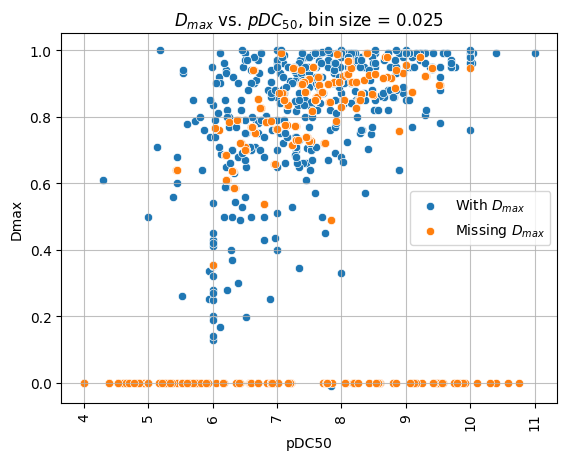

--------------------------------------------------------------------------------
bin size = 0.05
Min. num. of elements per bin: 1
Max. num. of elements per bin: 37
Avg. num. of elements per bin: 4.889
Num. of non-assigned Dmax values: 149 (20.50 %)


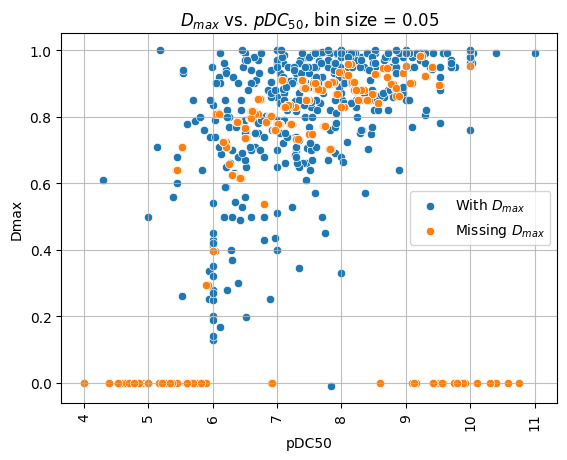

--------------------------------------------------------------------------------
bin size = 0.1
Min. num. of elements per bin: 1
Max. num. of elements per bin: 45
Avg. num. of elements per bin: 8.800
Num. of non-assigned Dmax values: 111 (15.27 %)


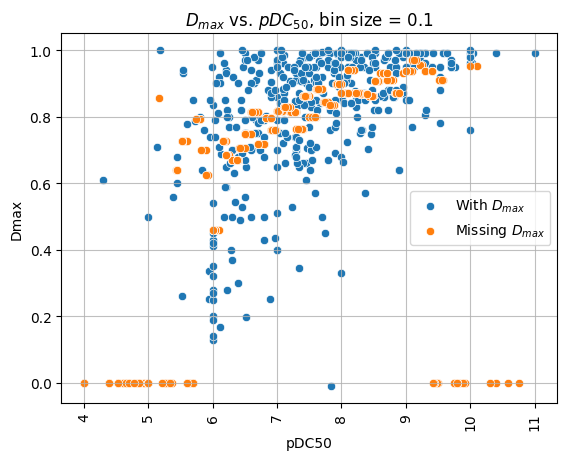

--------------------------------------------------------------------------------
bin size = 0.2
Min. num. of elements per bin: 1
Max. num. of elements per bin: 54
Avg. num. of elements per bin: 14.700
Num. of non-assigned Dmax values: 64 (8.80 %)


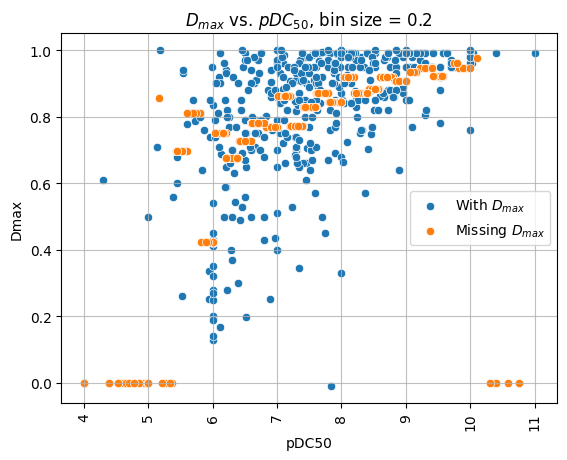

--------------------------------------------------------------------------------
bin size = 0.5
Min. num. of elements per bin: 1
Max. num. of elements per bin: 91
Avg. num. of elements per bin: 31.500
Num. of non-assigned Dmax values: 50 (6.88 %)


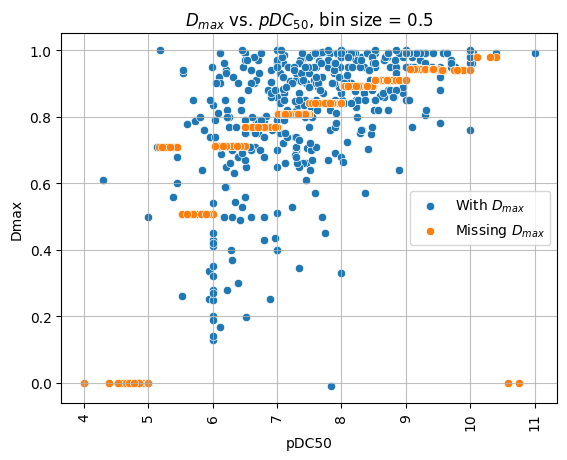

--------------------------------------------------------------------------------
bin size = 1
Min. num. of elements per bin: 2
Max. num. of elements per bin: 163
Avg. num. of elements per bin: 63.000
Num. of non-assigned Dmax values: 3 (0.41 %)


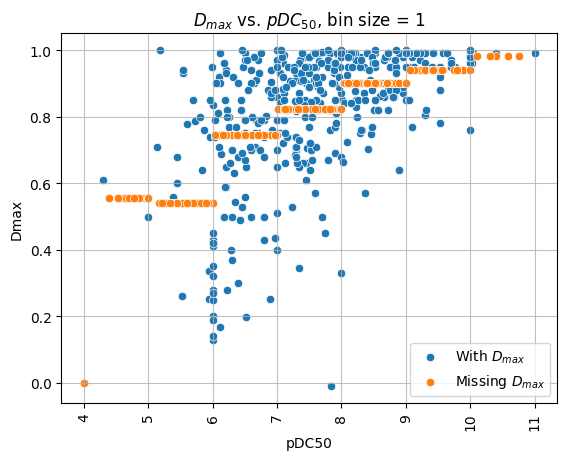

--------------------------------------------------------------------------------
bin size = 2
Min. num. of elements per bin: 4
Max. num. of elements per bin: 266
Avg. num. of elements per bin: 110.250
Num. of non-assigned Dmax values: 3 (0.41 %)


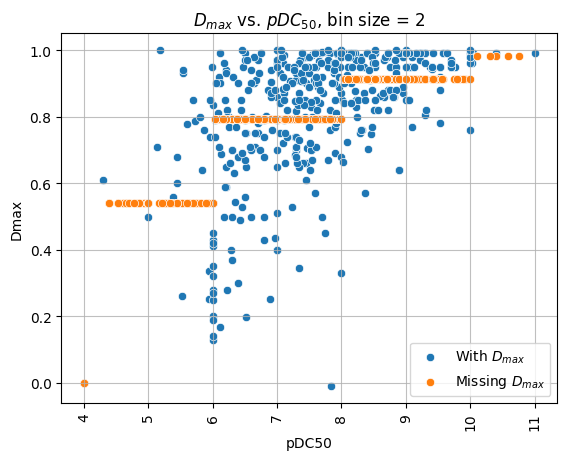

In [ ]:
df = dataframes['active_inactive: rows with active/inactive']
A = df[df['pDC50'].notnull() & df['Dmax'].notnull()].copy()
B = dataframes['no_dmax: rows with empty Dmax but with DC50'].copy()

# Define bin sizes
bin_sizes = [0.025, 0.05, 0.1, 0.2, 0.5, 1, 2]
# Loop over bin sizes
for i, bin_size in enumerate(bin_sizes):
    print('-' * 80)
    print(f'bin size = {bin_size}')

    B['Dmax'] = float('nan')
    B['Dmax'] = get_avg_Dmax(A, B, bin_size, verbose=1)
    # Fill NaN values in B with a desired value (e.g., NaN to 0), just for
    # plotting purposes
    B['Dmax'] = B['Dmax'].fillna(0)

    _ = sns.scatterplot(data=df, x='pDC50', y='Dmax', label='With $D_{max}$')
    _ = sns.scatterplot(data=B, x='pDC50', y='Dmax', label='Missing $D_{max}$')
    plt.legend()
    plt.xticks(rotation=90)
    plt.grid(axis='both', alpha=0.8)
    plt.title('$D_{max}$ vs. $pDC_{50}$' + f', bin size = {bin_size}')
    plt.savefig(os.path.join(fig_dir, f'gif_{i}.png'), transparent = False, facecolor = 'white')
    plt.show()

In [ ]:
import imageio
import os

frames = []
for i in range(7):
    image = imageio.v2.imread(os.path.join(fig_dir, f'gif_{i}.png'))
    frames.append(image)

imageio.mimsave(os.path.join(fig_dir, 'gif.gif'), # output gif
                frames,         # optional: frames per second
                duration=1000)               # duration per frame

--------------------------------------------------------------------------------
pDC50 >= 8.0:
--------------------------------------------------------------------------------
Min. num. of elements per bin: 1
Max. num. of elements per bin: 124
Avg. num. of elements per bin: 48.889
Num. of non-assigned Dmax values: 1 (0.50 %)
--------------------------------------------------------------------------------
pDC50 < 8.0:
--------------------------------------------------------------------------------
Min. num. of elements per bin: 1
Max. num. of elements per bin: 54
Avg. num. of elements per bin: 14.700
Num. of non-assigned Dmax values: 60 (11.41 %)
--------------------------------------------------------------------------------
Final num. of assigned Dmax values: 666 (91.61 %)
Final num. of non-assigned Dmax values: 61 (8.39 %)


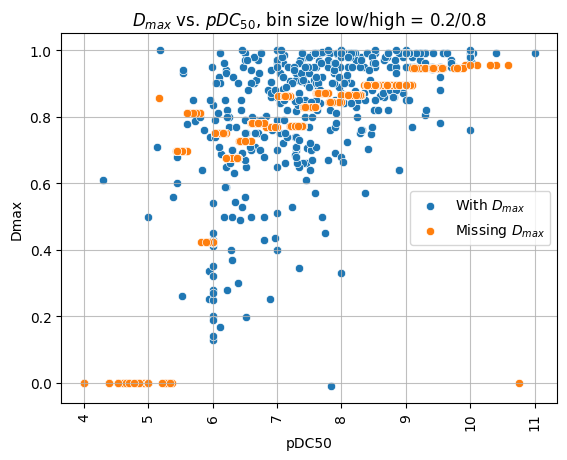

In [ ]:
df = dataframes['active_inactive: rows with active/inactive']
A = df[df['pDC50'].notnull() & df['Dmax'].notnull()].copy()
B = dataframes['no_dmax: rows with empty Dmax but with DC50'].copy()

B['Dmax'] = float('nan')
pDC50_threshold = 8.0
B_high = B[B['pDC50'] >= pDC50_threshold]
B_low = B[B['pDC50'] < pDC50_threshold]
bin_size_low = 0.2
bin_size_high = 0.8

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print('-' * 80)
    print(f'pDC50 >= {pDC50_threshold}:')
    print('-' * 80)
    B_high['Dmax'] = get_avg_Dmax(A, B_high, bin_size=bin_size_high, verbose=1)
    print('-' * 80)
    print(f'pDC50 < {pDC50_threshold}:')
    print('-' * 80)
    B_low['Dmax'] = get_avg_Dmax(A, B_low, bin_size=bin_size_low, verbose=1)
B = pd.concat([B_high, B_low])
B['active'] = B[['Dmax', 'pDC50']].apply(lambda x: is_active(x['pDC50'], x['Dmax']), axis=1)
dataframes['avg_dmax: rows with avg. Dmax'] = B.copy()

num_nans = len(B[B['Dmax'].isnull()])
print('-' * 80)
print(f'Final num. of assigned Dmax values: {len(B) - num_nans} ({(len(B) - num_nans) / len(B) * 100:.2f} %)')
print(f'Final num. of non-assigned Dmax values: {num_nans} ({num_nans / len(B) * 100:.2f} %)')

# Fill NaN values in B with a desired value (e.g., NaN to 0), just for
# plotting purposes
B['Dmax'] = B['Dmax'].fillna(0)
_ = sns.scatterplot(data=A, x='pDC50', y='Dmax', label='With $D_{max}$')
_ = sns.scatterplot(data=B, x='pDC50', y='Dmax', label='Missing $D_{max}$')
plt.legend()
plt.xticks(rotation=90)
plt.grid(axis='both', alpha=0.8)
plt.title('$D_{max}$ vs. $pDC_{50}$' + f', bin size low/high = {bin_size_low}/{bin_size_high}')
plt.show()


In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def hill_equation(x, E0, Einf, EC50, Hill_slope):
    """
    Hill equation function.
    x: independent variable (dose)
    a, b, c, d: parameters of the equation
    """
    return E0 + (Einf - E0) / (1 + np.exp(Hill_slope * (np.log(x) - np.log(EC50))))
    # return a + (b - a) / (1 + np.exp(d * (np.log(x) - np.log(c))))

def interpolate_dose_response(doses, responses, run_interpolation=False, num_interpolation_points=100):
    """
    Interpolates the points in a dose-response curve using the Hill equation.

    Parameters:
        doses (list or array): List of dose values.
        responses (list or array): List of response values corresponding to the doses.

    Returns:
        interpolated_doses (array): Array of interpolated dose values.
        interpolated_responses (array): Array of interpolated response values.

    Hill Equation:
        The Hill equation is used to model dose-response curves. It is defined as:
        f(x) = a + (b - a) / (1 + (x / c) ** d)

        where:
        - x: independent variable (dose)
        - a: lower asymptote or response value at low doses
        - b: upper asymptote or response value at high doses
        - c: dose at which the response is halfway between a and b (EC50)
        - d: Hill slope or the steepness of the curve.

    Interpolation:
        The function fits the Hill equation to the given dose-response data using
        curve fitting and then generates interpolated points along the curve.

    Example Usage:
        doses = [1, 2, 3, 4, 5]
        responses = [0.1, 0.4, 0.7, 0.9, 1.0]
        interpolated_doses, interpolated_responses = interpolate_dose_response(doses, responses)
    """

    # Fit the Hill equation to the data
    initial_guess = [np.min(responses), np.max(responses), np.median(doses), 1.0]
    params, _ = curve_fit(hill_equation, doses, responses, p0=initial_guess,
                          bounds=(0, 100))
    # Generate interpolated points
    interpolated_doses = np.linspace(min(doses), max(doses), num=len(doses) * num_interpolation_points)
    curve_points = ['D0', 'Dmax', 'pDC50', 'Hill']
    ret = {c: p for c, p in zip(curve_points, params)}
    if run_interpolation:
        interpolated_responses = hill_equation(interpolated_doses, *params)
        return ret, interpolated_doses, interpolated_responses
    else:
        return ret

In [ ]:
def remove_hook_effect(concentrations, degradations, threshold=0.1, sorted=False):
    """Remove points after hook effect, if detected.

    NOTE: Each concentration value is associated to the corresponding degradation value at the same index.
    If the concentrations are not sorted, then the function can sorte them.

    Args:
        concentrations (iterable): List of concentration values in -Log10 units.
        degradations (iterable): List of degradation response values in percentage.
        threshold (float, optional): If the next degradation value is higher than the previous one by a threshold percentage, then it is considered hook effect. Defaults to 0.1.

    Returns:
        Tuple: concentrations_nohook, degradations_nohook, hook_effect_happened
    """
    assert 0 <= threshold <= 1, f'Threshold must be between 0 and 1. Got instead: {threshold}'
    assert len(concentrations) == len(degradations)
    if not sorted:
        # Sort according to the concentrations, so that they are in descending
        # order. Without hook effect, the lower the concentration, the higher
        # the degradation will become.
        concentrations = np.array(concentrations)
        degradations = np.array(degradations)
        sorted_idx = list(reversed(np.argsort(concentrations)))
        concentrations = concentrations[sorted_idx]
        degradations = degradations[sorted_idx]
    max_degradation = min(degradations)
    concentrations_nohook, degradations_nohook = [], []
    hook_effect_happened = False
    for conc, degr in zip(concentrations, degradations):
        assert degr >= 0 and conc >= 0, f'Concentrations and degradations must be positive. Got instead: {conc} nM, {degr} %'
        if degr >= max_degradation:
            concentrations_nohook.append(conc)
            degradations_nohook.append(degr)
            max_degradation = degr
        else:
            if 1.0 - degr / max_degradation < threshold:
                concentrations_nohook.append(conc)
                degradations_nohook.append(degr)
                max_degradation = degr
            else:
                hook_effect_happened = True
                break
    return concentrations_nohook, degradations_nohook, hook_effect_happened

print('I should get the same lists:', remove_hook_effect([9.0, 8.0, 7.0, 6.0], [49.0, 84.0, 89.0, 97.0]))
print('Less strict threshold on hook effect definition:', remove_hook_effect([9.0, 8.0, 7.0, 6.0], [42.0, 76.0, 75.0, 21.0]))
print('Anything "decreasing" is removed:', remove_hook_effect([9.0, 8.0, 7.0, 6.0], [42.0, 76.0, 75.0, 21.0], threshold=0))

I should get the same lists: ([9.0, 8.0, 7.0, 6.0], [49.0, 84.0, 89.0, 97.0], False)
Less strict threshold on hook effect definition: ([9.0, 8.0, 7.0], [42.0, 76.0, 75.0], True)
Anything "decreasing" is removed: ([9.0, 8.0], [42.0, 76.0], True)


In [ ]:
from sklearn.linear_model import LinearRegression

def interpolate_pDC50_Dmax(assay_descr, degradation_descr,
                           plot_curve: bool = False,
                           lin_approx_rmsd_threshold: float = 3.0,
                           steepness_threshold: float = 0.25):
    """
    Interpolates the pDC50 and Dmax values from the assay and degradation descriptions.

    Parameters:
        assay_descr (str): Description of the assay.
        degradation_descr (str): Description of the degradation.

    Returns:
        pDC50 (float): Interpolated pDC50 value.
        Dmax (float): Interpolated Dmax value.
    """
    # Parse assay description
    assay = assay_descr.split('at')[-1]
    doses = split_clean_str(re.sub('[^0-9\./]', '', assay), return_floats=True)
    doses = [-np.log10(d * 1e-9) for d in doses]
    # Parse degradation description
    degradations = split_clean_str(degradation_descr, return_floats=True)
    # Remove hook effect
    assert len(doses) == len(degradations)
    doses, degradations, hook_effect_happened = remove_hook_effect(doses, degradations)
    # Interpolate dose-response curve
    default_params = params = {
        'D0': float('nan'),
        'Dmax': float('nan'),
        'pDC50': float('nan'),
        'Hill': float('nan'),
        'hook_effect': hook_effect_happened,
    }
    if len(doses) > 2:
        try:
            params = interpolate_dose_response(doses, degradations)
        except RuntimeError:
            print(f"WARNING: Curve fitting numerically failed. See SciPy documentation on `curve_fit` function.")
            return default_params
        params['hook_effect'] = hook_effect_happened
        # Check if RMSE of the interpolated curve compared to a linear fit is
        # less than a threshold value
        x_test = np.linspace(min(doses), max(doses), num=len(doses) * 100)
        # Get linear fit
        model = LinearRegression()
        model.fit(np.array(doses).reshape(-1, 1), np.array(degradations).reshape(-1, 1))
        y_lin = model.predict(x_test.reshape(-1, 1)).flatten()
        # Interpolate new points with the Hill equation defined by the
        # parameters just found
        y_hill = hill_equation(x_test,
                               E0=params['D0'],
                               Einf=params['Dmax'],
                               EC50=params['pDC50'],
                               Hill_slope=params['Hill'])
        # Calculate RMSD
        lin_points = np.array([x_test, y_lin]).T
        hill_points = np.array([x_test, y_hill]).T
        rmsd = np.sqrt(np.mean((lin_points - hill_points) ** 2))
        # If RMSD is less than a threshold, then the Hill equation is not a
        # good fit and the entry is discarded
        if rmsd < lin_approx_rmsd_threshold:
            print(f"WARNING: Hill function too close to a line curve, RMSD: {rmsd:.3f}.")
            params = default_params
        # Check if the curve is "too steep", i.e., w/out a "turning point"
        if min(doses) - steepness_threshold < params['pDC50'] < min(doses) + steepness_threshold:
            print(f"WARNING: Interpolated pDC50 is too close to the minimum dose value (interpolated/min: {params['pDC50']:.3f} / {min(doses):.3f}).")
            params = default_params
        if max(doses) - steepness_threshold < params['pDC50'] < max(doses) + steepness_threshold:
            print(f"WARNING: Interpolated pDC50 is too close to the maximum dose value (interpolated/max: {params['pDC50']:.3f} / {max(doses):.3f}).")
            params = default_params
        if plot_curve:
            # Plot original data and interpolated curve
            plt.scatter(doses, degradations, label='Original Data')
            plt.plot(x_test, y_hill, label='Hill func. Interpolation')
            plt.plot(x_test, y_lin, label='Linear Interpolation')
            plt.grid(alpha=0.7)
            plt.xlabel('$pDC_{50}$ (-Log10 units)')
            plt.ylabel('$D_{max}$ (%)')
            plt.gca().invert_xaxis()
            plt.gca().invert_yaxis()
            plt.legend()
            plt.show()
    return params

Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


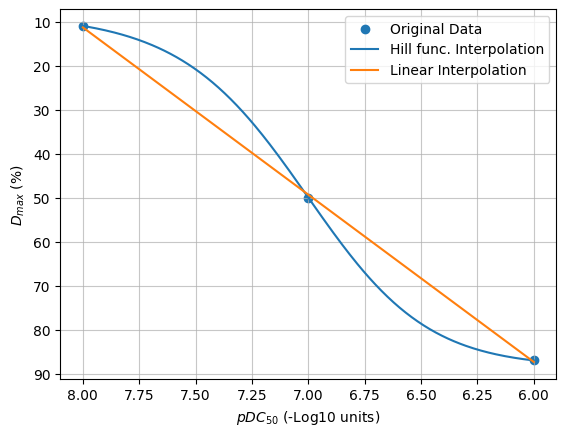

Interpolated pDC50: 7.02 (-Log10 units)
Interpolated Dmax: 88.42 (%)
--------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


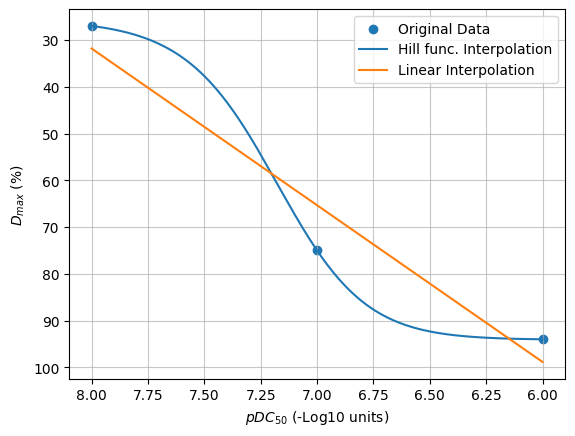

Interpolated pDC50: 7.19 (-Log10 units)
Interpolated Dmax: 94.10 (%)
--------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


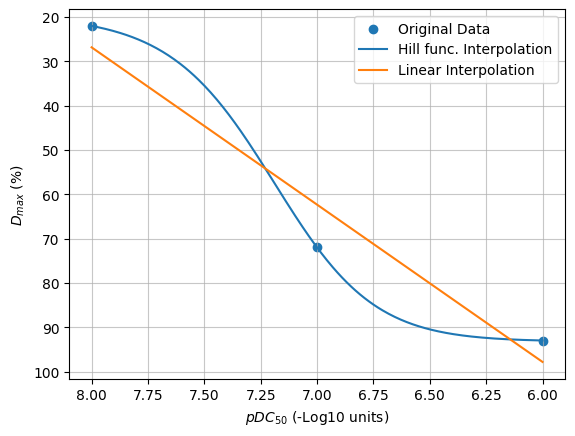

Interpolated pDC50: 7.20 (-Log10 units)
Interpolated Dmax: 93.22 (%)
--------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


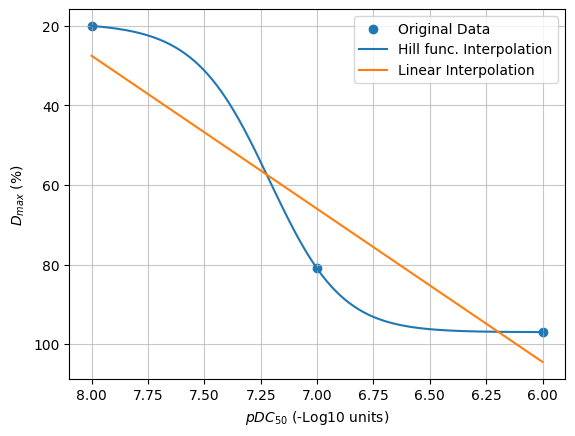

Interpolated pDC50: 7.22 (-Log10 units)
Interpolated Dmax: 97.02 (%)
--------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


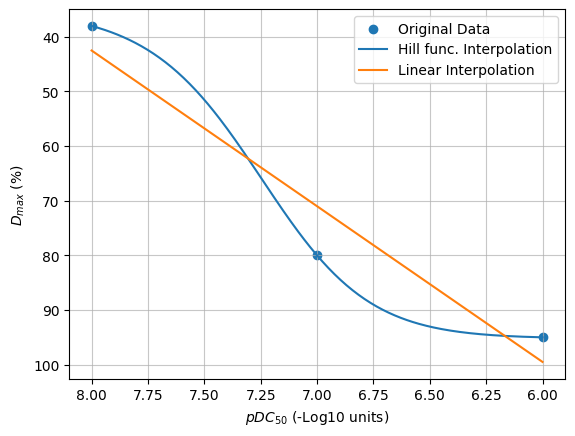

Interpolated pDC50: 7.26 (-Log10 units)
Interpolated Dmax: 95.21 (%)
--------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


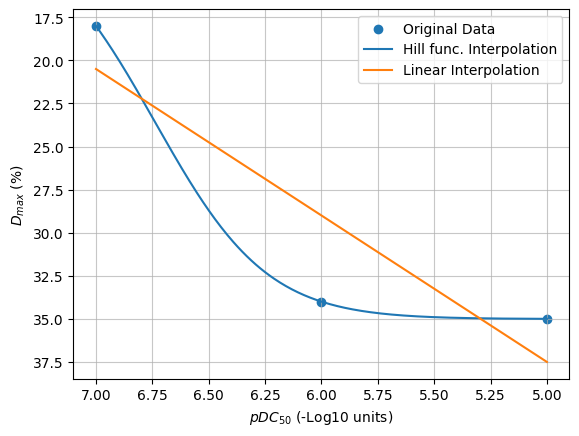

Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


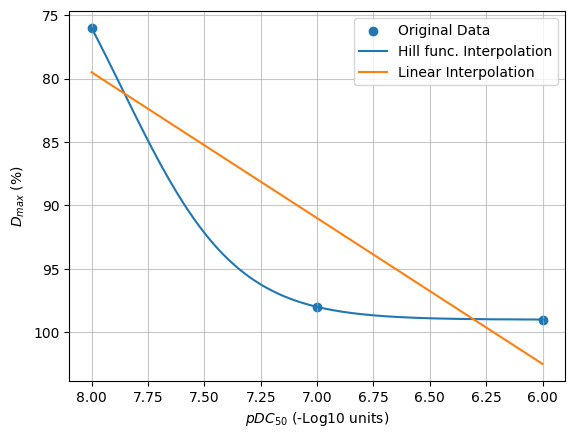

Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


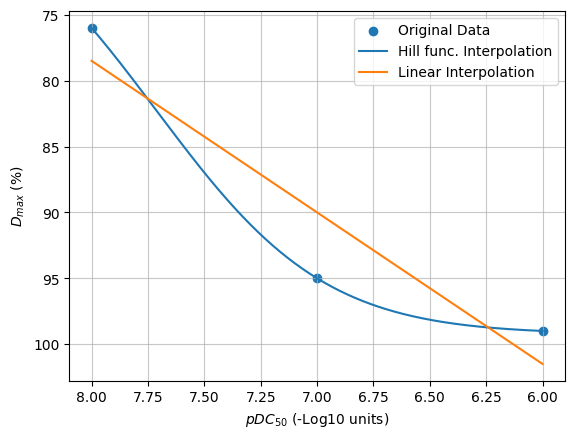

Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------
Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------
Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------
Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


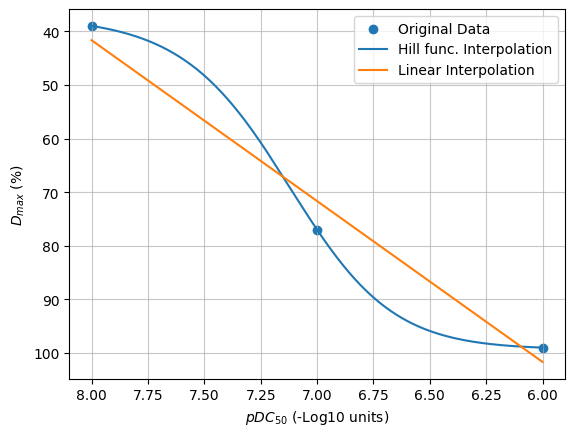

Interpolated pDC50: 7.13 (-Log10 units)
Interpolated Dmax: 99.31 (%)
--------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


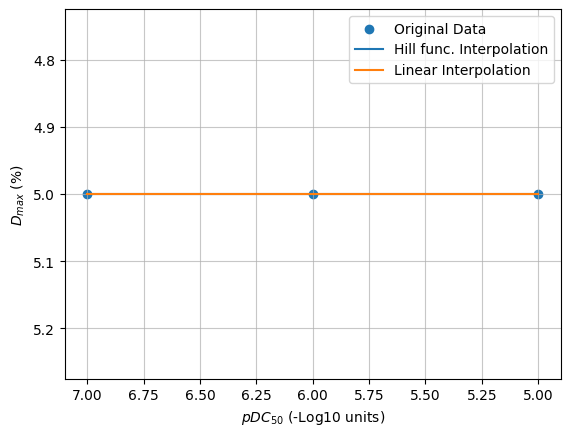

Interpolated pDC50: nan (-Log10 units)
Interpolated Dmax: nan (%)
--------------------------------------------------------------------------------


In [ ]:
for i in range(17, 31):
    row = dataframes[f'perc_degr_assay: rows with "Assay (Percent degradation)"'].iloc[i]
    assay_descr = row['Assay (Percent degradation)'].split('at')[-1]
    degradation_descr = row['Percent degradation (%)']
    params = interpolate_pDC50_Dmax(assay_descr, degradation_descr, plot_curve=True)

    print(f'Interpolated pDC50: {params["pDC50"]:.2f} (-Log10 units)')
    print(f'Interpolated Dmax: {params["Dmax"]:.2f} (%)')
    print('-' * 80)

In [ ]:
def clean_perc_degr_entries(row):
    assay_descr = row['Assay (Percent degradation)'].split('at')[-1]
    degradation_descr = row['Percent degradation (%)']
    params = interpolate_pDC50_Dmax(assay_descr, degradation_descr)
    row['DC50'] = 10**(-params['pDC50']) # Expressed in M
    row['pDC50'] = params['pDC50']
    row['Dmax'] = params['Dmax'] / 100.0
    row['hook_effect'] = params['hook_effect']
    row['active'] = True if (row['pDC50'] >= 7.0) and (row['Dmax'] >= 0.8) else False
    row['hook_effect'] = params['hook_effect']
    # Get cell type
    cell_type = row['Assay (Percent degradation)'].split('in')[-1]
    cell_type = cell_type.split('cells')[0].strip()
    row['cell_type'] = cell_type
    # Get POI gene ID
    gene_id = row['Assay (Percent degradation)'].split('% ')[-1]
    gene_id = gene_id.split('degradation')[0].strip()
    row['poi_gene_id_parsed'] = gene_id
    # Apply mutation to POI sequence
    row['poi_sequence'] = apply_mutation(row['Uniprot'], row['poi_gene_id'], row['poi_seq'], on_error='ignore')
    # Get treatment hours
    if 'treatment' in row['Assay (Percent degradation)']:
        treatment_hours = row['Assay (Percent degradation)'].split('after')[-1]
        treatment_hours = treatment_hours.split('h treatment')[0].strip()
    else:
        treatment_hours = float('nan')
    row['treatment_hours'] = treatment_hours
    return row

In [ ]:
df = dataframes[f'perc_degr_assay: rows with "Assay (Percent degradation)"']
interpolated_df = df.apply(clean_perc_degr_entries, axis=1)
tmp = interpolated_df.dropna(subset=['pDC50', 'Dmax', 'hook_effect'])
cols_to_show = [
    'Assay (Percent degradation)',
    'poi_gene_id_parsed',
    'cell_type',
    'treatment_hours',
    'pDC50',
    'Dmax',
    'active',
    'hook_effect',
]
display(tmp[cols_to_show].head())
print('-' * 80)
print(f'Number of entries with interpolated pDC50 and Dmax: {len(tmp)}')
print(f'Percentage of entries with successfully interpolated pDC50 and Dmax: {len(tmp) / len(df) * 100:.2f}%')
dataframes[f'interpolated_dc50: rows with interpolated percent degradation'] = interpolated_df

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be e

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be e

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be e

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be e

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be e

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be e

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be e

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be e

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be e

WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be e

WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.
WARNING. Replacement at position 857 failed. Expected "L", found: "R". No mutation applied.


,Assay (Percent degradation),poi_gene_id_parsed,cell_type,treatment_hours,pDC50,Dmax,active,hook_effect
134,% AR degradation in LNCaP cells after 6 h trea...,AR,LNCaP,6,6.867694,0.662907,False,False
135,% AR degradation in LNCaP cells after 6 h trea...,AR,LNCaP,6,7.156384,0.870556,True,False
136,% AR degradation in LNCaP cells after 6 h trea...,AR,LNCaP,6,7.000827,0.927833,True,False
137,% AR degradation in LNCaP cells after 6 h trea...,AR,LNCaP,6,7.008338,0.897034,True,False
138,% AR degradation in LNCaP cells after 6 h trea...,AR,LNCaP,6,6.258717,0.750021,False,False


--------------------------------------------------------------------------------
Number of entries with interpolated pDC50 and Dmax: 56
Percentage of entries with successfully interpolated pDC50 and Dmax: 15.47%


In [ ]:
dataframes['ssl: SSL dataframe'] = pd.DataFrame()

print(f'Extracting entries with missing active/inactive:')
for k, v in dataframes.items():
    if 'rows with active/inactive' in k or 'ssl: SSL dataframe' in k:
        continue
    print(f'From dataframe: "{k}"...')
    if 'active' not in v.columns:
        no_activity_df = v
    else:
        no_activity_df = v[v['active'].isnull()]
    dataframes['ssl: SSL dataframe'] = pd.concat([dataframes['ssl: SSL dataframe'], no_activity_df], axis=0, ignore_index=True)
dataframes['ssl: SSL dataframe'] = dataframes['ssl: SSL dataframe'].drop_duplicates()
print('-' * 80)
print(f'Number of entries with no activity: {len(dataframes["ssl: SSL dataframe"])}')
dataframes['ssl: SSL dataframe'][dataframes['ssl: SSL dataframe']['active'].isnull()]

Extracting entries with missing active/inactive:
From dataframe: "non_degrading: rows with no degradation"...
From dataframe: "no_assay_info: rows with no assay info"...
From dataframe: "perc_degr_assay: rows with "Assay (Percent degradation)""...
From dataframe: "dc50_dmax_assay: rows with "Assay (DC50/Dmax)""...
From dataframe: "no_dmax: rows with empty Dmax but with DC50"...
From dataframe: "no_dc50: rows with empty DC50 but with Dmax"...
From dataframe: "avg_dmax: rows with avg. Dmax"...
From dataframe: "interpolated_dc50: rows with interpolated percent degradation"...
--------------------------------------------------------------------------------
Number of entries with no activity: 4545


,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),Percent degradation (%),Assay (Percent degradation),"IC50 (nM, Protac to Target)","Assay (Protac to Target, IC50)","EC50 (nM, Protac to Target)","Assay (Protac to Target, EC50)","Kd (nM, Protac to Target)","Assay (Protac to Target, Kd)","Ki (nM, Protac to Target)","Assay (Protac to Target, Ki)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)","Assay (Protac to Target, G/H/-TS)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)","Assay (Protac to Target, kon/koff/t1/2)","IC50 (nM, Protac to E3)","Assay (Protac to E3, IC50)","EC50 (nM, Protac to E3)","Assay (Protac to E3, EC50)","Kd (nM, Protac to E3)","Assay (Protac to E3, Kd)","Ki (nM, Protac to E3)","Assay (Protac to E3, Ki)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)","Assay (Protac to E3, G/H/-TS)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)","Assay (Protac to E3, kon/koff/t1/2)","IC50 (nM, Ternary complex)","Assay (Ternary complex, IC50)","EC50 (nM, Ternary complex)","Assay (Ternary complex, EC50)","Kd (nM, Ternary complex)","Assay (Ternary complex, Kd)","Ki (nM, Ternary complex)","Assay (Ternary complex, Ki)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)","Assay (Ternary complex, G/H/-TS)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)","Assay (Ternary complex, kon/koff/t1/2)","IC50 (nM, Cellular activities)","Assay (Cellular activities, IC50)","EC50 (nM, Cellular activities)","Assay (Cellular activities, EC50)","GI50 (nM, Cellular activities)","Assay (Cellular activities, GI50)","ED50 (nM, Cellular activities)","Assay (Cellular activities, ED50)","GR50 (nM, Cellular activities)","Assay (Cellular activities, GR50)","PAMPA Papp (nm/s, Permeability)","Assay (Permeability, PAMPA Papp)","Caco-2 A2B Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 A2B Papp)","Caco-2 B2A Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 B2A Papp)",Article DOI,Molecular Weight,Exact Mass,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,poi_seq,Smiles_no_stereo,e3_ligase_gene,e3_ligase_seq,cell_type,treatment_hours,active,hook_effect,DC50,pDC50,Dmax,poi_gene_id_parsed,hook_effectpoi_gene_id_parsed,poi_sequence
0,1,Q9NPI1,BRD7,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01413,953.176,952.451697,3.03,68,7,15,3,19,189.92,C50H64N8O9S,InChI=1S/C50H64N8O9S/c1-32-45(68-31-53-32)34-1...,RPMQBLMPGMFXLD-PDUNVWSESA-N,MGKKHKKHKSDKHLYEEYVEKPLKLVLKVGGNEVTELSTGSSGHDS...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Q9H8M2,BRD9,VHL,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,ITC,NaN,NaN,-10.7,-12.5,1.8,ITC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33/24,ITC/FP,NaN,NaN,-10.2,-15.2,4.9,ITC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73/98,ITC/FP,NaN,NaN,-9.7,-6.4,-3.3,ITC between VHL and BRD9-BD:PROTAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1021/acs.jmedchem.8b01413,953.176,952.451697,3.03,68,7,15,3,19,189.92,C50H64N8O9S,InChI=1S/C50H64N8O9S/c1-32-45(68-31-53-32)34-1...,RPMQBLMPGMFXLD-PDUNVWSESA-N,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSG...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)

In [ ]:
# TODO
dataframes['ssl: SSL dataframe'] = dataframes['ssl: SSL dataframe'][~dataframes['ssl: SSL dataframe'].isin(dataframes['active_inactive: rows with active/inactive'])]
dataframes['ssl: SSL dataframe']

,Compound ID,Uniprot,poi_gene_id,e3_ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),Percent degradation (%),Assay (Percent degradation),"IC50 (nM, Protac to Target)","Assay (Protac to Target, IC50)","EC50 (nM, Protac to Target)","Assay (Protac to Target, EC50)","Kd (nM, Protac to Target)","Assay (Protac to Target, Kd)","Ki (nM, Protac to Target)","Assay (Protac to Target, Ki)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)","Assay (Protac to Target, G/H/-TS)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)","Assay (Protac to Target, kon/koff/t1/2)","IC50 (nM, Protac to E3)","Assay (Protac to E3, IC50)","EC50 (nM, Protac to E3)","Assay (Protac to E3, EC50)","Kd (nM, Protac to E3)","Assay (Protac to E3, Kd)","Ki (nM, Protac to E3)","Assay (Protac to E3, Ki)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)","Assay (Protac to E3, G/H/-TS)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)","Assay (Protac to E3, kon/koff/t1/2)","IC50 (nM, Ternary complex)","Assay (Ternary complex, IC50)","EC50 (nM, Ternary complex)","Assay (Ternary complex, EC50)","Kd (nM, Ternary complex)","Assay (Ternary complex, Kd)","Ki (nM, Ternary complex)","Assay (Ternary complex, Ki)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)","Assay (Ternary complex, G/H/-TS)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)","Assay (Ternary complex, kon/koff/t1/2)","IC50 (nM, Cellular activities)","Assay (Cellular activities, IC50)","EC50 (nM, Cellular activities)","Assay (Cellular activities, EC50)","GI50 (nM, Cellular activities)","Assay (Cellular activities, GI50)","ED50 (nM, Cellular activities)","Assay (Cellular activities, ED50)","GR50 (nM, Cellular activities)","Assay (Cellular activities, GR50)","PAMPA Papp (nm/s, Permeability)","Assay (Permeability, PAMPA Papp)","Caco-2 A2B Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 A2B Papp)","Caco-2 B2A Papp (nm/s, Permeability)","Assay (Permeability, Caco-2 B2A Papp)",Article DOI,Molecular Weight,Exact Mass,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,poi_seq,Smiles_no_stereo,e3_ligase_gene,e3_ligase_seq,cell_type,treatment_hours,active,hook_effect,DC50,pDC50,Dmax,poi_gene_id_parsed,hook_effectpoi_gene_id_parsed,poi_sequence
0,1,Q9NPI1,BRD7,NaN,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,953.176,952.451697,3.03,68,7,15,NaN,19,189.92,C50H64N8O9S,InChI=1S/C50H64N8O9S/c1-32-45(68-31-53-32)34-1...,RPMQBLMPGMFXLD-PDUNVWSESA-N,MGKKHKKHKSDKHLYEEYVEKPLKLVLKVGGNEVTELSTGSSGHDS...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN,-10.7,-12.5,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33/24,NaN,NaN,NaN,-10.2,-15.2,4.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73/98,NaN,NaN,NaN,-9.7,-6.4,-3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,953.176,952.451697,3.03,68,7,15,NaN,NaN,189.92,C50H64N8O9S,InChI=1S/C50H64N8O9S/c1-32-45(68-31-53-32)34-1...,RPMQBLMPGMFXLD-PDUNVWSESA-N,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
dataframes['perc_degr_assay: rows with "Assay (Percent degradation)"']['Dmax'] = float('nan')

<ipython-input-63-5401489bf9cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['perc_degr_assay: rows with "Assay (Percent degradation)"']['Dmax'] = float('nan')


In [ ]:
columns_to_check = [
    'Smiles',
    'Smiles_no_stereo',
    'DC50',
    'pDC50',
    'Dmax',
    'poi_gene_id',
    'poi_seq',
    'cell_type',
    'treatment_hours',
    'e3_ligase',
    'active',
]
for k, v in dataframes.items():
    print(f'"{k}": {len(v)}')
    df_id = k.split(':')[0].strip()
    csv_name = f'protac_db_{df_id}.csv'
    filename = os.path.join(data_dir, 'processed', csv_name)
    v.to_csv(filename, index=False)
    # Check if all columns are present
    cols = pd.read_csv(filename).reset_index(drop=True).columns
    for c in columns_to_check:
        if c not in cols:
            print(f'\tERROR. Column {c} not found in: {csv_name}')

"non_degrading: rows with no degradation": 339
"no_assay_info: rows with no assay info": 3737
"perc_degr_assay: rows with "Assay (Percent degradation)"": 362
"dc50_dmax_assay: rows with "Assay (DC50/Dmax)"": 1276
"no_dmax: rows with empty Dmax but with DC50": 727
"no_dc50: rows with empty DC50 but with Dmax": 86
"active_inactive: rows with active/inactive": 822
"avg_dmax: rows with avg. Dmax": 727
"interpolated_dc50: rows with interpolated percent degradation": 362
"ssl: SSL dataframe": 4545
